# Language Translation
In this project, you’re going to take a peek into the realm of neural network machine translation.  You’ll be training a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French.
## Get the Data
Since translating the whole language of English to French will take lots of time to train, we have provided you with a small portion of the English corpus.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests
import matplotlib.pyplot as plt
import random

source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = helper.load_data(source_path)
target_text = helper.load_data(target_path)

## Explore the Data
Play around with view_sentence_range to view different parts of the data.

In [44]:
view_sentence_range = (25, 35)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))

print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 227
Number of sentences: 137861
Average number of words in a sentence: 13.225277634719028

English sentences 25 to 35:
california is never cold during may , and it is sometimes chilly in march .
he dislikes lemons , grapes , and mangoes.
their favorite fruit is the mango , but our favorite is the pear .
france is sometimes quiet during may , and it is never chilly in august .
paris is never pleasant during september , and it is beautiful in autumn .
he dislikes apples , peaches , and grapes .
california is usually freezing during december , and it is busy in april .
your most feared animal is that shark .
paris is usually wet during august , and it is never dry in november .
paris is usually beautiful during september , and it is usually snowy in november .

French sentences 25 to 35:
californie ne fait jamais froid au mois de mai , et il est parfois frisquet en mars .
il déteste les citrons , les raisins et les mangues .
leur fruit pré

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

In [45]:
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """
    # Looks like the tests want a *list of nested lists*, where each nested list is a sentence (line) from the input str
    source_id_text = [[source_vocab_to_int[word] for word in sentence.split()] for sentence in source_text.split('\n')]
    # Do the same, but add the <EOS> tag at the end of *each* sentence in the target str
    target_id_text = [[target_vocab_to_int[word] for word in (sentence + ' <EOS>').split()] 
                      for sentence in target_text.split('\n')]
    return source_id_text, target_id_text

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_text_to_ids(text_to_ids)

Tests Passed


### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
helper.preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import helper

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from tensorflow.python.layers.core import Dense

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoder_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.
- Target sequence length placeholder named "target_sequence_length" with rank 1
- Max target sequence length tensor named "max_target_len" getting its value from applying tf.reduce_max on the target_sequence_length placeholder. Rank 0.
- Source sequence length placeholder named "source_sequence_length" with rank 1

Return the placeholders in the following the tuple (input, targets, learning rate, keep probability, target sequence length, max target sequence length, source sequence length)

In [49]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, learning rate, and lengths of source and target sequences.
    :return: Tuple (input, targets, learning rate, keep probability, target sequence length,
    max target sequence length, source sequence length)
    """
    # build the inputs one at a time
    input_text = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    target_sequence_length = tf.placeholder(tf.int32, [None], name='target_sequence_length')
    max_target_len = tf.reduce_max(target_sequence_length, name= "max_target_len")
    source_sequence_len = tf.placeholder(tf.int32, [None], name='source_sequence_length')
    return input_text, targets, learning_rate, keep_prob, target_sequence_length, max_target_len, source_sequence_len


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Process Decoder Input
Implement `process_decoder_input` by removing the last word id from each batch in `target_data` and concat the GO ID to the begining of each batch.

In [50]:
def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for encoding
    :param target_data: Target Placehoder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    targets = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    return tf.concat([tf.fill([batch_size, 1], target_vocab_to_int['<GO>']), targets], 1)
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_process_encoding_input(process_decoder_input)

Tests Passed


### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer:
 * Embed the encoder input using [`tf.contrib.layers.embed_sequence`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence)
 * Construct a [stacked](https://github.com/tensorflow/tensorflow/blob/6947f65a374ebf29e74bb71e36fd82760056d82c/tensorflow/docs_src/tutorials/recurrent.md#stacking-multiple-lstms) [`tf.contrib.rnn.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell) wrapped in a [`tf.contrib.rnn.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper)
 * Pass cell and embedded input to [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)

In [51]:
from imp import reload
reload(tests)

def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, 
                   source_sequence_length, source_vocab_size, 
                   encoding_embedding_size):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :param source_sequence_length: a list of the lengths of each sequence in the batch
    :param source_vocab_size: vocabulary size of source data
    :param encoding_embedding_size: embedding size of source data
    :return: tuple (RNN output, RNN state)
    """
    # Create the embedding
    embedded = tf.contrib.layers.embed_sequence(rnn_inputs, source_vocab_size, encoding_embedding_size)
    
    # Stack the LSTM cells, with dropout
    def lstm_cell():
        return tf.contrib.rnn.DropoutWrapper(
            tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.random_uniform_initializer(-0.1, 0.1)), output_keep_prob=keep_prob)
    stacked_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(num_layers)])
    
    # Build the encoder RNN
    rnn_output, rnn_state = tf.nn.dynamic_rnn(stacked_lstm, embedded, sequence_length=source_sequence_length, dtype=tf.float32)
    
    return rnn_output, rnn_state

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_encoding_layer(encoding_layer)

Tests Passed


### Decoding - Training
Create a training decoding layer:
* Create a [`tf.contrib.seq2seq.TrainingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/TrainingHelper) 
* Create a [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
* Obtain the decoder outputs from [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)

In [52]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                         target_sequence_length, max_summary_length, 
                         output_layer, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param target_sequence_length: The lengths of each sequence in the target batch
    :param max_summary_length: The length of the longest sequence in the batch
    :param output_layer: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: BasicDecoderOutput containing training logits and sample_id
    """
    # Build the training helper
    helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input, sequence_length=target_sequence_length)
    
    # Build the decoder- add dropout to the decoder cell
    training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, helper, encoder_state, output_layer)
        
    # Perform the decoding. Unpack 2 values
    decoded, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder, 
                                                      impute_finished=True, maximum_iterations=max_summary_length)
    
    # Return the decoded outputs
    return decoded



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_train(decoding_layer_train)

Tests Passed


### Decoding - Inference
Create inference decoder:
* Create a [`tf.contrib.seq2seq.GreedyEmbeddingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/GreedyEmbeddingHelper)
* Create a [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
* Obtain the decoder outputs from [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)

In [53]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id,
                         end_of_sequence_id, max_target_sequence_length,
                         vocab_size, output_layer, batch_size, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS ID
    :param max_target_sequence_length: Maximum length of target sequences
    :param vocab_size: Size of decoder/target vocabulary
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_layer: Function to apply the output layer
    :param batch_size: Batch size
    :param keep_prob: Dropout keep probability
    :return: BasicDecoderOutput containing inference logits and sample_id
    """

    # Build the <GO> tokens
    tokens = tf.tile(tf.constant([start_of_sequence_id], dtype=tf.int32), [batch_size], name='start_tokens')
    
    # Build the greedy embedding helper
    helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings, tokens, end_of_sequence_id)
    
    # Build the decoder
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, helper, encoder_state, output_layer)

    # Perform the actual unrolling and decoding (again, with 3 outputs to unpack)
    dec_output, _ = tf.contrib.seq2seq.dynamic_decode(decoder, impute_finished=True, 
                                                         maximum_iterations=max_target_sequence_length)       

    return dec_output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

* Embed the target sequences
* Construct the decoder LSTM cell (just like you constructed the encoder cell above)
* Create an output layer to map the outputs of the decoder to the elements of our vocabulary
* Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, target_sequence_length, max_target_sequence_length, output_layer, keep_prob)` function to get the training logits.
* Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, max_target_sequence_length, vocab_size, output_layer, batch_size, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [54]:
def decoding_layer(dec_input, encoder_state,
                   target_sequence_length, max_target_sequence_length,
                   rnn_size,
                   num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):
    """
    Create decoding layer
    :param dec_input: Decoder input
    :param encoder_state: Encoder state
    :param target_sequence_length: The lengths of each sequence in the target batch
    :param max_target_sequence_length: Maximum length of target sequences
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param target_vocab_size: Size of target vocabulary
    :param batch_size: The size of the batch
    :param keep_prob: Dropout keep probability
    :param decoding_embedding_size: Decoding embedding size
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    
    # First, embed the target sequences
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    embedded = tf.contrib.layers.embed_sequence(dec_input, target_vocab_size, decoding_embedding_size)

    # Stack the decoder LSTM cells, with dropout
    def lstm_cell():
        return tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(rnn_size, 
                                                                     initializer=tf.random_uniform_initializer(-0.1, 0.1)), 
                                                                     output_keep_prob=keep_prob)
    dec_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(num_layers)])

    # Define a linear dense layer to map outputs to words
    output_layer = Dense(target_vocab_size, kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))

    # Define the scope for training
    with tf.variable_scope("decode"):
        # Get the training logits
        train_logits = decoding_layer_train(encoder_state, dec_cell, embedded,
                         target_sequence_length, max_target_sequence_length, output_layer, keep_prob)

    # Define the scope for inference
    with tf.variable_scope("decode", reuse=True):
        # Get the inference logits
        inference_logits = decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, target_vocab_to_int['<GO>'],
                                                target_vocab_to_int['<EOS>'], max_target_sequence_length, 
                                                target_vocab_size, output_layer, batch_size, keep_prob)

    return train_logits, inference_logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer(decoding_layer)

Tests Passed


### Build the Neural Network
Apply the functions you implemented above to:

- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob,  source_sequence_length, source_vocab_size, encoding_embedding_size)`.
- Process target data using your `process_decoder_input(target_data, target_vocab_to_int, batch_size)` function.
- Decode the encoded input using your `decoding_layer(dec_input, enc_state, target_sequence_length, max_target_sentence_length, rnn_size, num_layers, target_vocab_to_int, target_vocab_size, batch_size, keep_prob, dec_embedding_size)` function.

In [55]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size,
                  source_sequence_length, target_sequence_length,
                  max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :param input_data: Input placeholder
    :param target_data: Target placeholder
    :param keep_prob: Dropout keep probability placeholder
    :param batch_size: Batch Size
    :param source_sequence_length: Sequence Lengths of source sequences in the batch
    :param target_sequence_length: Sequence Lengths of target sequences in the batch
    :param source_vocab_size: Source vocabulary size
    :param target_vocab_size: Target vocabulary size
    :param enc_embedding_size: Decoder embedding size
    :param dec_embedding_size: Encoder embedding size
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    # First, encode the input data
    encoded, enc_state = encoding_layer(input_data, rnn_size, num_layers, keep_prob, source_sequence_length, source_vocab_size, 
                                        enc_embedding_size)
    
    # Process the decoder input
    dec_in = process_decoder_input(target_data, target_vocab_to_int, batch_size)

    # Decode the the encoded input
    train, infer = decoding_layer(dec_in, enc_state, target_sequence_length, max_target_sentence_length, rnn_size, 
                                  num_layers, target_vocab_to_int, target_vocab_size, batch_size, keep_prob, dec_embedding_size)
    
    # Return the results
    return train, infer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_seq2seq_model(seq2seq_model)

Tests Passed


## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability
- Set `display_step` to state how many steps between each debug output statement

In [56]:
# Number of Epochs
#epochs = 10
# Batch Size
batch_size = 256
# RNN Size
#rnn_size = 128
# Number of Layers
#num_layers = 2
# Embedding Size
#encoding_embedding_size = 256
#decoding_embedding_size = 256
# Learning Rate
#learning_rate = 0.001
# Dropout Keep Probability
#keep_probability = 0.6
#display_step = 10

Batch and pad the source and target sequences

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]


def get_batches(sources, targets, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size

        # Slice the right amount for the batch
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]

        # Pad
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))

        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))

        yield pad_sources_batch, pad_targets_batch, pad_source_lengths, pad_targets_lengths


### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forms to see if anyone is having the same problem.

New hyperparameters:
RNN size = 64
Embedding size = 64
Epoch   0 Batch    0/538 - Train Accuracy: 0.2475, Validation Accuracy: 0.3276, Loss: 5.8804
Epoch   0 Batch   10/538 - Train Accuracy: 0.2602, Validation Accuracy: 0.3471, Loss: 3.8474
Epoch   0 Batch   20/538 - Train Accuracy: 0.3265, Validation Accuracy: 0.3707, Loss: 3.3282
Epoch   0 Batch   30/538 - Train Accuracy: 0.3146, Validation Accuracy: 0.3832, Loss: 3.3261
Epoch   0 Batch   40/538 - Train Accuracy: 0.3871, Validation Accuracy: 0.3968, Loss: 2.9167
Epoch   0 Batch   50/538 - Train Accuracy: 0.3289, Validation Accuracy: 0.3837, Loss: 3.0370
Epoch   0 Batch   60/538 - Train Accuracy: 0.3611, Validation Accuracy: 0.4210, Loss: 2.9834
Epoch   0 Batch   70/538 - Train Accuracy: 0.4014, Validation Accuracy: 0.4293, Loss: 2.7913
Epoch   0 Batch   80/538 - Train Accuracy: 0.3859, Validation Accuracy: 0.4457, Loss: 2.8402
Epoch   0 Batch   90/538 - Train Accuracy: 0.4193, Validation Accuracy: 0.4556, Loss: 2.6866
Epoch   0 Batch

Epoch   1 Batch  340/538 - Train Accuracy: 0.1230, Validation Accuracy: 0.1243, Loss: 0.9236
Epoch   1 Batch  350/538 - Train Accuracy: 0.1090, Validation Accuracy: 0.1088, Loss: 0.9090
Epoch   1 Batch  360/538 - Train Accuracy: 0.1082, Validation Accuracy: 0.1156, Loss: 0.9187
Epoch   1 Batch  370/538 - Train Accuracy: 0.1145, Validation Accuracy: 0.1103, Loss: 0.9154
Epoch   1 Batch  380/538 - Train Accuracy: 0.1107, Validation Accuracy: 0.1040, Loss: 0.8899
Epoch   1 Batch  390/538 - Train Accuracy: 0.1280, Validation Accuracy: 0.1174, Loss: 0.8396
Epoch   1 Batch  400/538 - Train Accuracy: 0.1096, Validation Accuracy: 0.1005, Loss: 0.8737
Epoch   1 Batch  410/538 - Train Accuracy: 0.1055, Validation Accuracy: 0.1028, Loss: 0.8778
Epoch   1 Batch  420/538 - Train Accuracy: 0.1213, Validation Accuracy: 0.1186, Loss: 0.8651
Epoch   1 Batch  430/538 - Train Accuracy: 0.1145, Validation Accuracy: 0.1058, Loss: 0.8723
Epoch   1 Batch  440/538 - Train Accuracy: 0.1258, Validation Accuracy

Epoch   3 Batch  150/538 - Train Accuracy: 0.1994, Validation Accuracy: 0.1804, Loss: 0.7170
Epoch   3 Batch  160/538 - Train Accuracy: 0.1944, Validation Accuracy: 0.1994, Loss: 0.6850
Epoch   3 Batch  170/538 - Train Accuracy: 0.1855, Validation Accuracy: 0.1703, Loss: 0.7043
Epoch   3 Batch  180/538 - Train Accuracy: 0.1918, Validation Accuracy: 0.1923, Loss: 0.7044
Epoch   3 Batch  190/538 - Train Accuracy: 0.2189, Validation Accuracy: 0.2044, Loss: 0.7189
Epoch   3 Batch  200/538 - Train Accuracy: 0.2084, Validation Accuracy: 0.2102, Loss: 0.7072
Epoch   3 Batch  210/538 - Train Accuracy: 0.2059, Validation Accuracy: 0.2090, Loss: 0.7121
Epoch   3 Batch  220/538 - Train Accuracy: 0.1838, Validation Accuracy: 0.1960, Loss: 0.6864
Epoch   3 Batch  230/538 - Train Accuracy: 0.2051, Validation Accuracy: 0.1953, Loss: 0.7177
Epoch   3 Batch  240/538 - Train Accuracy: 0.2096, Validation Accuracy: 0.2081, Loss: 0.7312
Epoch   3 Batch  250/538 - Train Accuracy: 0.2070, Validation Accuracy

Epoch   4 Batch  500/538 - Train Accuracy: 0.1978, Validation Accuracy: 0.1935, Loss: 0.6007
Epoch   4 Batch  510/538 - Train Accuracy: 0.2109, Validation Accuracy: 0.1864, Loss: 0.6343
Epoch   4 Batch  520/538 - Train Accuracy: 0.2059, Validation Accuracy: 0.1850, Loss: 0.6760
Epoch   4 Batch  530/538 - Train Accuracy: 0.2080, Validation Accuracy: 0.1813, Loss: 0.6765


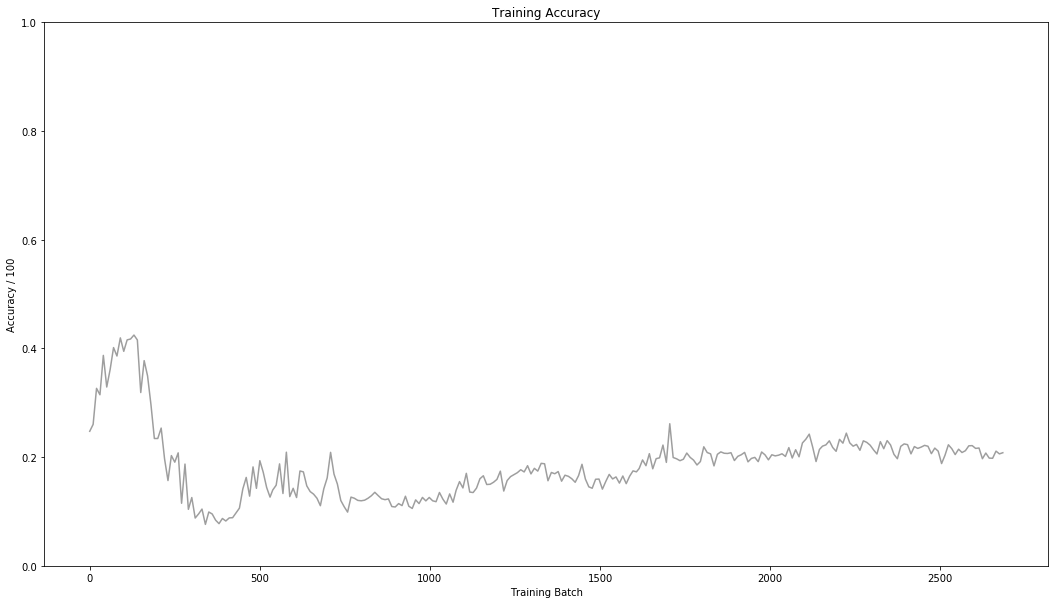

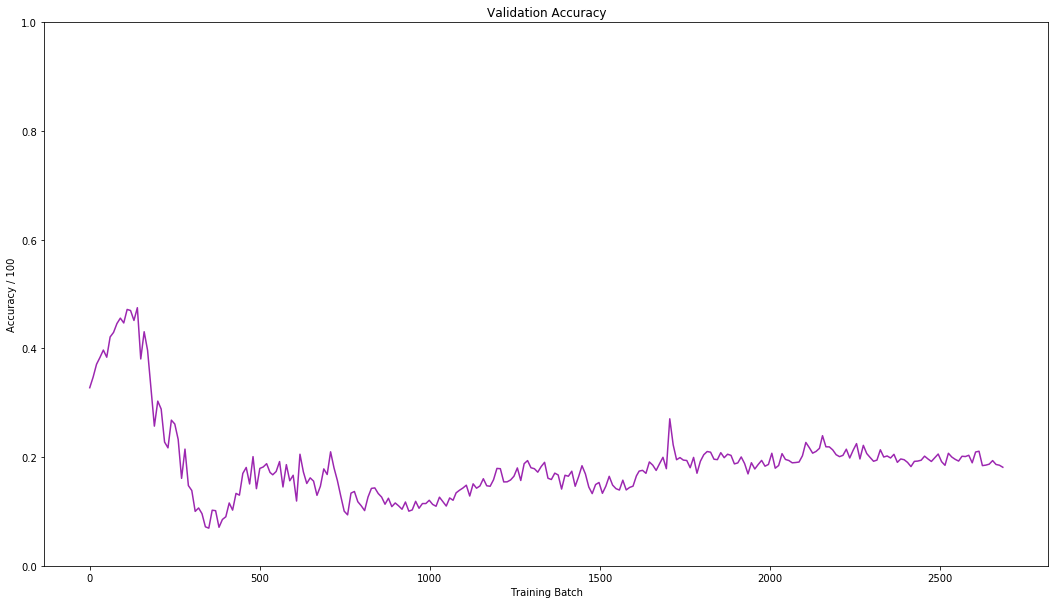

Mean validation accuracy in last ten samples is: 0.1912

Hyperparameters used:
RNN size: 64
Embedding size: 64

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 64
Embedding size = 128
Epoch   0 Batch    0/538 - Train Accuracy: 0.0566, Validation Accuracy: 0.0483, Loss: 5.8806
Epoch   0 Batch   10/538 - Train Accuracy: 0.2602, Validation Accuracy: 0.3471, Loss: 3.8477
Epoch   0 Batch   20/538 - Train Accuracy: 0.2991, Validation Accuracy: 0.3469, Loss: 3.3604
Epoch   0 Batch   30/538 - Train Accuracy: 0.3107, Validation Accuracy: 0.3771, Loss: 3.3589
Epoch   0 Batch   40/538 - Train Accuracy: 0.3780, Validation Accuracy: 0.3844, Loss: 2.9255
Epoch   0 Batch   50/538 - Train Accuracy: 0.3092, Validation Accuracy: 0.3720, Loss: 3.0490
Epoch   0 Batch   60/538 - Train Accuracy: 0.3094, Validation Accuracy: 0.3775, Loss: 2.9588
Epoch   0 Batch   70/538 - Train Accuracy: 0.3305, Validation Accuracy: 0.3873, Loss: 2.7486
Epoch   0 Batch   

Epoch   1 Batch  320/538 - Train Accuracy: 0.1313, Validation Accuracy: 0.1323, Loss: 0.8347
Epoch   1 Batch  330/538 - Train Accuracy: 0.1332, Validation Accuracy: 0.1333, Loss: 0.8212
Epoch   1 Batch  340/538 - Train Accuracy: 0.1561, Validation Accuracy: 0.1376, Loss: 0.8757
Epoch   1 Batch  350/538 - Train Accuracy: 0.1339, Validation Accuracy: 0.1286, Loss: 0.8679
Epoch   1 Batch  360/538 - Train Accuracy: 0.1486, Validation Accuracy: 0.1458, Loss: 0.8707
Epoch   1 Batch  370/538 - Train Accuracy: 0.1488, Validation Accuracy: 0.1413, Loss: 0.8629
Epoch   1 Batch  380/538 - Train Accuracy: 0.1488, Validation Accuracy: 0.1390, Loss: 0.8414
Epoch   1 Batch  390/538 - Train Accuracy: 0.1583, Validation Accuracy: 0.1420, Loss: 0.8182
Epoch   1 Batch  400/538 - Train Accuracy: 0.1330, Validation Accuracy: 0.1401, Loss: 0.8194
Epoch   1 Batch  410/538 - Train Accuracy: 0.1291, Validation Accuracy: 0.1220, Loss: 0.8331
Epoch   1 Batch  420/538 - Train Accuracy: 0.1404, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.1698, Validation Accuracy: 0.1536, Loss: 0.6653
Epoch   3 Batch  140/538 - Train Accuracy: 0.1682, Validation Accuracy: 0.1554, Loss: 0.7307
Epoch   3 Batch  150/538 - Train Accuracy: 0.1781, Validation Accuracy: 0.1483, Loss: 0.6938
Epoch   3 Batch  160/538 - Train Accuracy: 0.1654, Validation Accuracy: 0.1536, Loss: 0.6560
Epoch   3 Batch  170/538 - Train Accuracy: 0.1788, Validation Accuracy: 0.1653, Loss: 0.6866
Epoch   3 Batch  180/538 - Train Accuracy: 0.1788, Validation Accuracy: 0.1650, Loss: 0.6772
Epoch   3 Batch  190/538 - Train Accuracy: 0.1650, Validation Accuracy: 0.1658, Loss: 0.6981
Epoch   3 Batch  200/538 - Train Accuracy: 0.1840, Validation Accuracy: 0.1630, Loss: 0.6687
Epoch   3 Batch  210/538 - Train Accuracy: 0.1763, Validation Accuracy: 0.1667, Loss: 0.6769
Epoch   3 Batch  220/538 - Train Accuracy: 0.1771, Validation Accuracy: 0.1612, Loss: 0.6659
Epoch   3 Batch  230/538 - Train Accuracy: 0.1834, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.1840, Validation Accuracy: 0.1705, Loss: 0.6008
Epoch   4 Batch  490/538 - Train Accuracy: 0.1728, Validation Accuracy: 0.1767, Loss: 0.6150
Epoch   4 Batch  500/538 - Train Accuracy: 0.1861, Validation Accuracy: 0.1839, Loss: 0.5698
Epoch   4 Batch  510/538 - Train Accuracy: 0.1953, Validation Accuracy: 0.1737, Loss: 0.6076
Epoch   4 Batch  520/538 - Train Accuracy: 0.1959, Validation Accuracy: 0.1722, Loss: 0.6514
Epoch   4 Batch  530/538 - Train Accuracy: 0.1883, Validation Accuracy: 0.1733, Loss: 0.6449


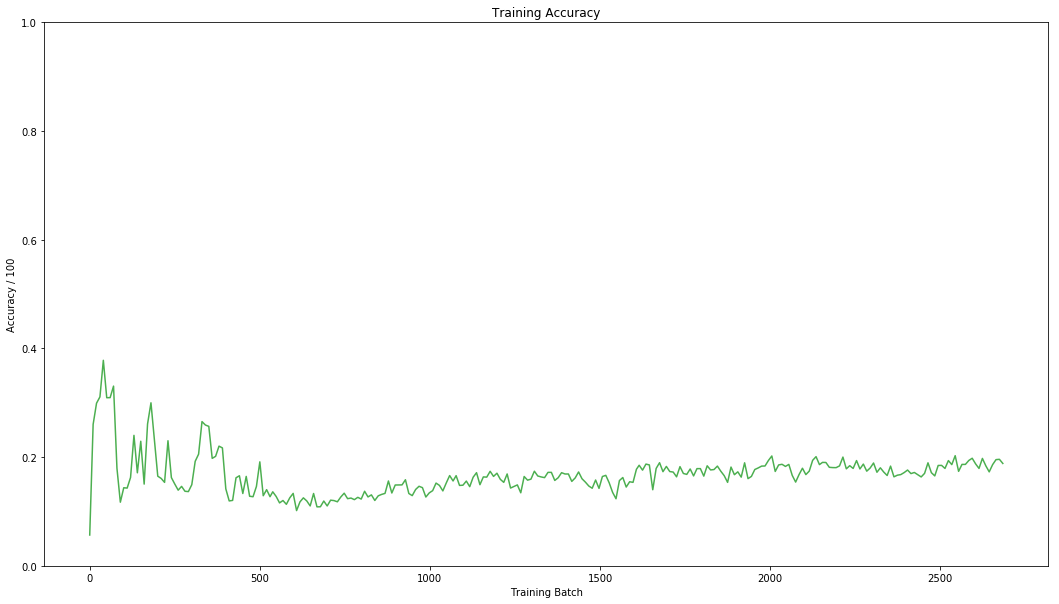

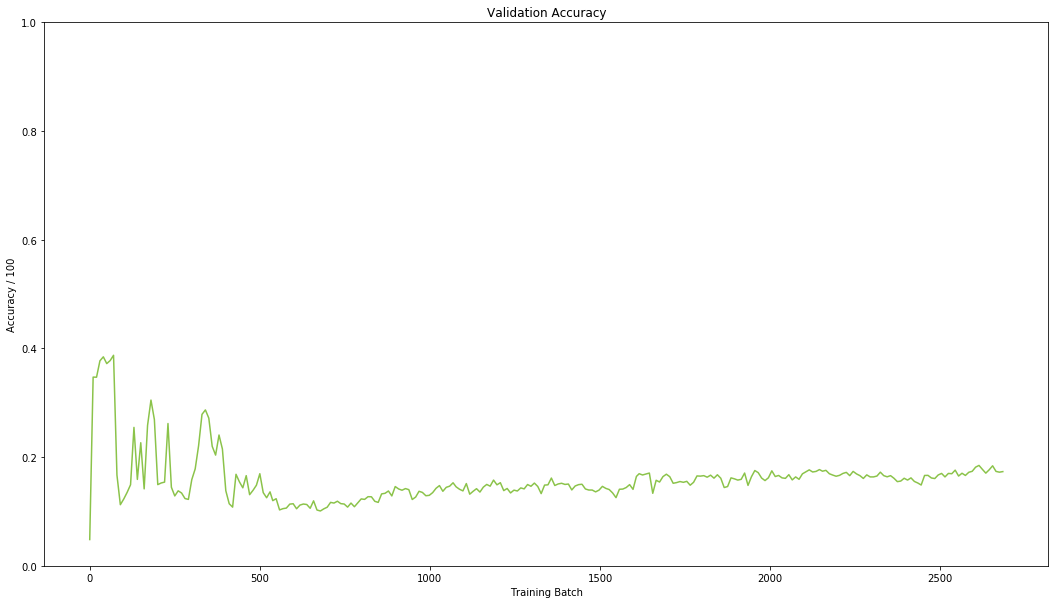

Mean validation accuracy in last ten samples is: 0.1768

Hyperparameters used:
RNN size: 64
Embedding size: 128

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 64
Embedding size = 256
Epoch   0 Batch    0/538 - Train Accuracy: 0.2734, Validation Accuracy: 0.3517, Loss: 5.8807
Epoch   0 Batch   10/538 - Train Accuracy: 0.2611, Validation Accuracy: 0.3473, Loss: 3.8073
Epoch   0 Batch   20/538 - Train Accuracy: 0.3266, Validation Accuracy: 0.3691, Loss: 3.2502
Epoch   0 Batch   30/538 - Train Accuracy: 0.3514, Validation Accuracy: 0.4128, Loss: 3.1988
Epoch   0 Batch   40/538 - Train Accuracy: 0.4094, Validation Accuracy: 0.4141, Loss: 2.7722
Epoch   0 Batch   50/538 - Train Accuracy: 0.3658, Validation Accuracy: 0.4157, Loss: 2.8931
Epoch   0 Batch   60/538 - Train Accuracy: 0.3432, Validation Accuracy: 0.4009, Loss: 2.8481
Epoch   0 Batch   70/538 - Train Accuracy: 0.2762, Validation Accuracy: 0.3089, Loss: 2.6139
Epoch   0 Batch  

Epoch   1 Batch  320/538 - Train Accuracy: 0.0753, Validation Accuracy: 0.0605, Loss: 0.8731
Epoch   1 Batch  330/538 - Train Accuracy: 0.0772, Validation Accuracy: 0.0648, Loss: 0.8476
Epoch   1 Batch  340/538 - Train Accuracy: 0.0813, Validation Accuracy: 0.0625, Loss: 0.9134
Epoch   1 Batch  350/538 - Train Accuracy: 0.0731, Validation Accuracy: 0.0668, Loss: 0.9165
Epoch   1 Batch  360/538 - Train Accuracy: 0.0842, Validation Accuracy: 0.0669, Loss: 0.9026
Epoch   1 Batch  370/538 - Train Accuracy: 0.0818, Validation Accuracy: 0.0680, Loss: 0.8949
Epoch   1 Batch  380/538 - Train Accuracy: 0.0746, Validation Accuracy: 0.0675, Loss: 0.8534
Epoch   1 Batch  390/538 - Train Accuracy: 0.0718, Validation Accuracy: 0.0652, Loss: 0.8639
Epoch   1 Batch  400/538 - Train Accuracy: 0.0802, Validation Accuracy: 0.0673, Loss: 0.8672
Epoch   1 Batch  410/538 - Train Accuracy: 0.0795, Validation Accuracy: 0.0661, Loss: 0.8663
Epoch   1 Batch  420/538 - Train Accuracy: 0.0764, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.0947, Validation Accuracy: 0.0794, Loss: 0.6998
Epoch   3 Batch  140/538 - Train Accuracy: 0.0879, Validation Accuracy: 0.0748, Loss: 0.7573
Epoch   3 Batch  150/538 - Train Accuracy: 0.0887, Validation Accuracy: 0.0701, Loss: 0.7201
Epoch   3 Batch  160/538 - Train Accuracy: 0.0951, Validation Accuracy: 0.0783, Loss: 0.6893
Epoch   3 Batch  170/538 - Train Accuracy: 0.0952, Validation Accuracy: 0.0792, Loss: 0.7110
Epoch   3 Batch  180/538 - Train Accuracy: 0.0978, Validation Accuracy: 0.0827, Loss: 0.6902
Epoch   3 Batch  190/538 - Train Accuracy: 0.0967, Validation Accuracy: 0.0842, Loss: 0.6970
Epoch   3 Batch  200/538 - Train Accuracy: 0.1047, Validation Accuracy: 0.0835, Loss: 0.6878
Epoch   3 Batch  210/538 - Train Accuracy: 0.0969, Validation Accuracy: 0.0829, Loss: 0.6893
Epoch   3 Batch  220/538 - Train Accuracy: 0.0969, Validation Accuracy: 0.0829, Loss: 0.6616
Epoch   3 Batch  230/538 - Train Accuracy: 0.0961, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.1135, Validation Accuracy: 0.0948, Loss: 0.5696
Epoch   4 Batch  490/538 - Train Accuracy: 0.1064, Validation Accuracy: 0.0994, Loss: 0.5692
Epoch   4 Batch  500/538 - Train Accuracy: 0.1115, Validation Accuracy: 0.0966, Loss: 0.5217
Epoch   4 Batch  510/538 - Train Accuracy: 0.1109, Validation Accuracy: 0.1005, Loss: 0.5492
Epoch   4 Batch  520/538 - Train Accuracy: 0.1109, Validation Accuracy: 0.1000, Loss: 0.6090
Epoch   4 Batch  530/538 - Train Accuracy: 0.1129, Validation Accuracy: 0.1042, Loss: 0.6037


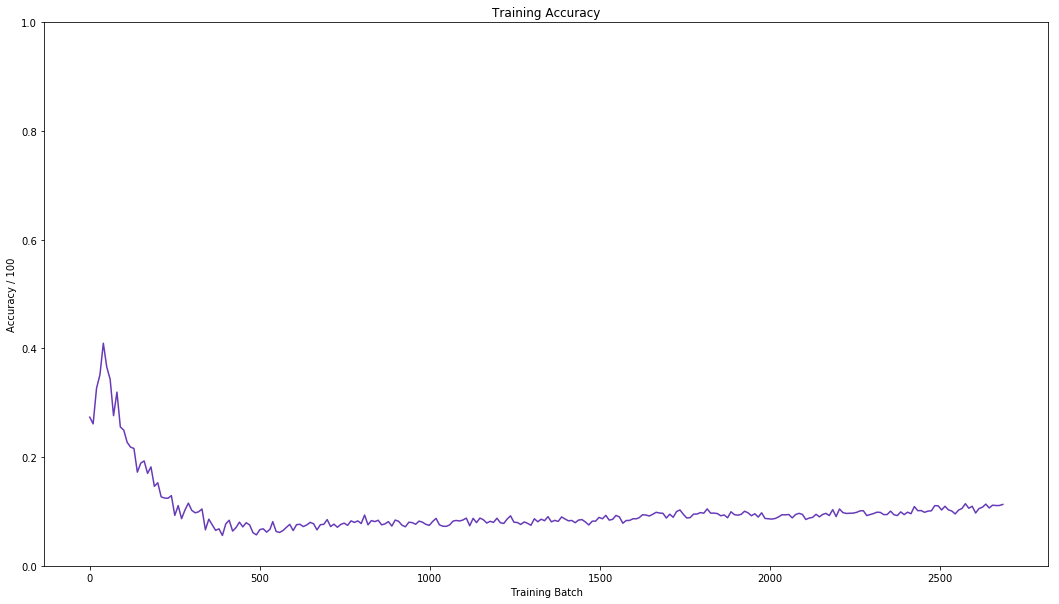

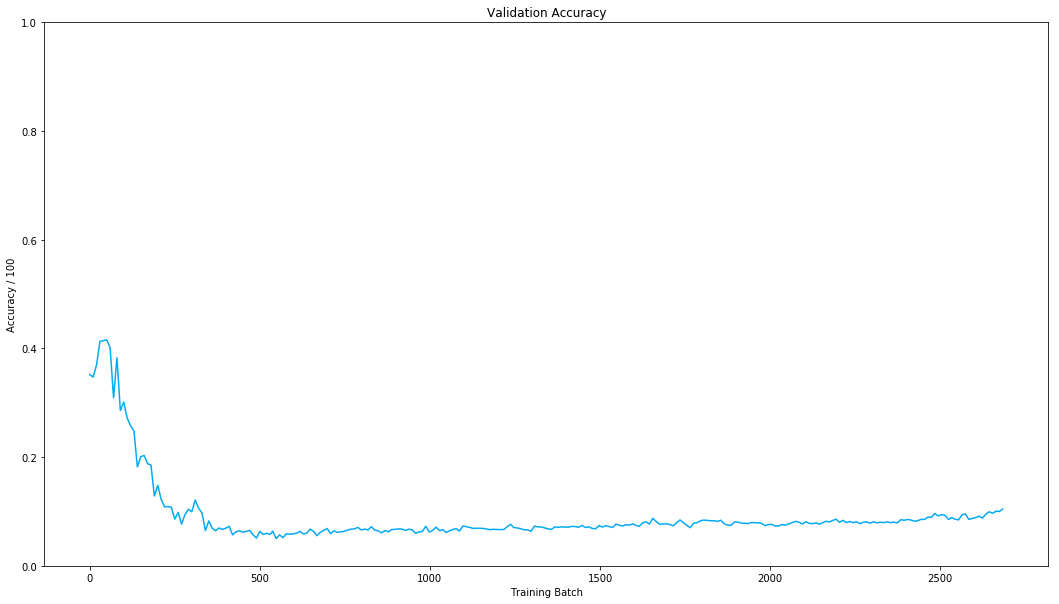

Mean validation accuracy in last ten samples is: 0.0950

Hyperparameters used:
RNN size: 64
Embedding size: 256

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 128
Embedding size = 64
Epoch   0 Batch    0/538 - Train Accuracy: 0.2678, Validation Accuracy: 0.3443, Loss: 5.8811
Epoch   0 Batch   10/538 - Train Accuracy: 0.2738, Validation Accuracy: 0.3576, Loss: 3.6523
Epoch   0 Batch   20/538 - Train Accuracy: 0.3430, Validation Accuracy: 0.3812, Loss: 3.1235
Epoch   0 Batch   30/538 - Train Accuracy: 0.3543, Validation Accuracy: 0.4185, Loss: 2.9849
Epoch   0 Batch   40/538 - Train Accuracy: 0.3803, Validation Accuracy: 0.3809, Loss: 2.4887
Epoch   0 Batch   50/538 - Train Accuracy: 0.2117, Validation Accuracy: 0.2147, Loss: 2.4650
Epoch   0 Batch   60/538 - Train Accuracy: 0.2373, Validation Accuracy: 0.2656, Loss: 2.2967
Epoch   0 Batch   70/538 - Train Accuracy: 0.1637, Validation Accuracy: 0.1422, Loss: 2.0931
Epoch   0 Batch  

Epoch   1 Batch  320/538 - Train Accuracy: 0.0921, Validation Accuracy: 0.0794, Loss: 0.6604
Epoch   1 Batch  330/538 - Train Accuracy: 0.0880, Validation Accuracy: 0.0794, Loss: 0.6227
Epoch   1 Batch  340/538 - Train Accuracy: 0.0936, Validation Accuracy: 0.0776, Loss: 0.6842
Epoch   1 Batch  350/538 - Train Accuracy: 0.0915, Validation Accuracy: 0.0799, Loss: 0.6707
Epoch   1 Batch  360/538 - Train Accuracy: 0.0801, Validation Accuracy: 0.0687, Loss: 0.6701
Epoch   1 Batch  370/538 - Train Accuracy: 0.0887, Validation Accuracy: 0.0849, Loss: 0.6711
Epoch   1 Batch  380/538 - Train Accuracy: 0.0881, Validation Accuracy: 0.0781, Loss: 0.6407
Epoch   1 Batch  390/538 - Train Accuracy: 0.0763, Validation Accuracy: 0.0728, Loss: 0.6271
Epoch   1 Batch  400/538 - Train Accuracy: 0.0958, Validation Accuracy: 0.0826, Loss: 0.6318
Epoch   1 Batch  410/538 - Train Accuracy: 0.1031, Validation Accuracy: 0.0895, Loss: 0.6442
Epoch   1 Batch  420/538 - Train Accuracy: 0.0893, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.1397, Validation Accuracy: 0.1220, Loss: 0.4884
Epoch   3 Batch  140/538 - Train Accuracy: 0.1457, Validation Accuracy: 0.1296, Loss: 0.5230
Epoch   3 Batch  150/538 - Train Accuracy: 0.1377, Validation Accuracy: 0.1149, Loss: 0.5041
Epoch   3 Batch  160/538 - Train Accuracy: 0.1518, Validation Accuracy: 0.1280, Loss: 0.4845
Epoch   3 Batch  170/538 - Train Accuracy: 0.1592, Validation Accuracy: 0.1328, Loss: 0.5207
Epoch   3 Batch  180/538 - Train Accuracy: 0.1334, Validation Accuracy: 0.1236, Loss: 0.4945
Epoch   3 Batch  190/538 - Train Accuracy: 0.1168, Validation Accuracy: 0.1211, Loss: 0.5122
Epoch   3 Batch  200/538 - Train Accuracy: 0.1518, Validation Accuracy: 0.1300, Loss: 0.4940
Epoch   3 Batch  210/538 - Train Accuracy: 0.1304, Validation Accuracy: 0.1186, Loss: 0.5012
Epoch   3 Batch  220/538 - Train Accuracy: 0.1304, Validation Accuracy: 0.1220, Loss: 0.4841
Epoch   3 Batch  230/538 - Train Accuracy: 0.1410, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.1637, Validation Accuracy: 0.1671, Loss: 0.4275
Epoch   4 Batch  490/538 - Train Accuracy: 0.1620, Validation Accuracy: 0.1632, Loss: 0.4250
Epoch   4 Batch  500/538 - Train Accuracy: 0.1831, Validation Accuracy: 0.1699, Loss: 0.3886
Epoch   4 Batch  510/538 - Train Accuracy: 0.1988, Validation Accuracy: 0.1786, Loss: 0.4145
Epoch   4 Batch  520/538 - Train Accuracy: 0.2057, Validation Accuracy: 0.2008, Loss: 0.4368
Epoch   4 Batch  530/538 - Train Accuracy: 0.1764, Validation Accuracy: 0.1887, Loss: 0.4263


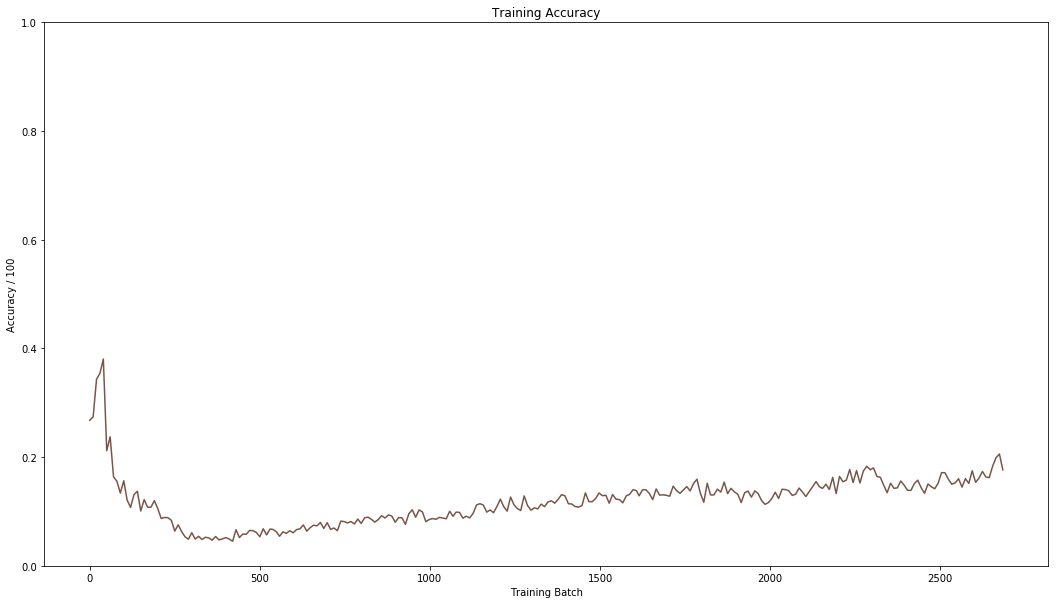

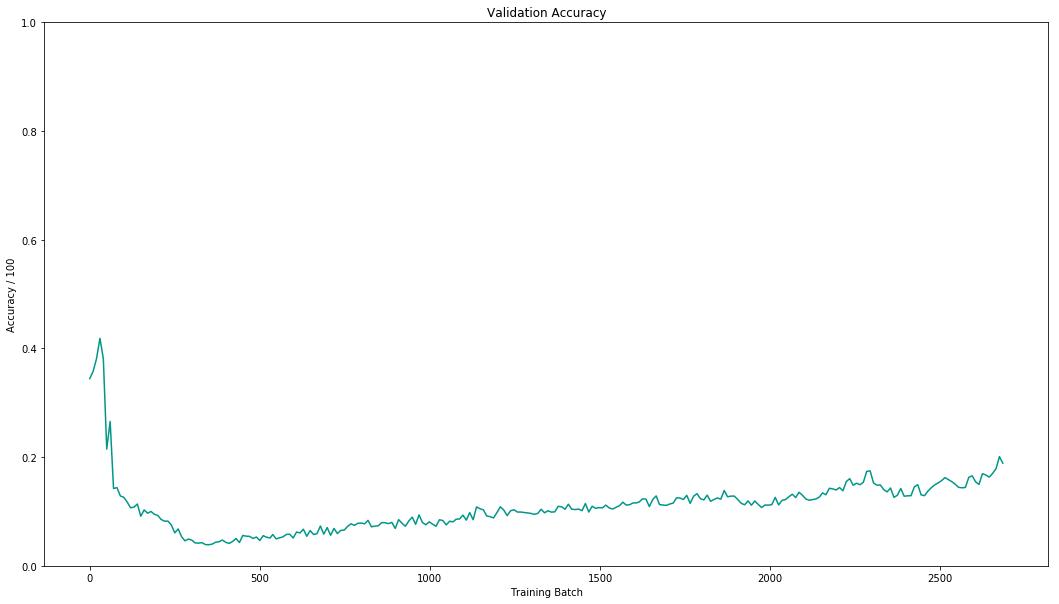

Mean validation accuracy in last ten samples is: 0.1707

Hyperparameters used:
RNN size: 128
Embedding size: 64

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 128
Embedding size = 128
Epoch   0 Batch    0/538 - Train Accuracy: 0.0395, Validation Accuracy: 0.0327, Loss: 5.8804
Epoch   0 Batch   10/538 - Train Accuracy: 0.2859, Validation Accuracy: 0.3617, Loss: 3.5343
Epoch   0 Batch   20/538 - Train Accuracy: 0.3398, Validation Accuracy: 0.3819, Loss: 3.0714
Epoch   0 Batch   30/538 - Train Accuracy: 0.3482, Validation Accuracy: 0.4128, Loss: 2.9498
Epoch   0 Batch   40/538 - Train Accuracy: 0.3981, Validation Accuracy: 0.4057, Loss: 2.5800
Epoch   0 Batch   50/538 - Train Accuracy: 0.3465, Validation Accuracy: 0.4043, Loss: 2.4900
Epoch   0 Batch   60/538 - Train Accuracy: 0.3424, Validation Accuracy: 0.4176, Loss: 2.3489
Epoch   0 Batch   70/538 - Train Accuracy: 0.3586, Validation Accuracy: 0.4052, Loss: 2.0947
Epoch   0 Batch 

Epoch   1 Batch  320/538 - Train Accuracy: 0.3199, Validation Accuracy: 0.3489, Loss: 0.6461
Epoch   1 Batch  330/538 - Train Accuracy: 0.3943, Validation Accuracy: 0.4242, Loss: 0.6183
Epoch   1 Batch  340/538 - Train Accuracy: 0.2604, Validation Accuracy: 0.3139, Loss: 0.6825
Epoch   1 Batch  350/538 - Train Accuracy: 0.2837, Validation Accuracy: 0.3130, Loss: 0.6626
Epoch   1 Batch  360/538 - Train Accuracy: 0.2910, Validation Accuracy: 0.3512, Loss: 0.6660
Epoch   1 Batch  370/538 - Train Accuracy: 0.2809, Validation Accuracy: 0.3253, Loss: 0.6636
Epoch   1 Batch  380/538 - Train Accuracy: 0.3195, Validation Accuracy: 0.3643, Loss: 0.6425
Epoch   1 Batch  390/538 - Train Accuracy: 0.3144, Validation Accuracy: 0.3601, Loss: 0.6190
Epoch   1 Batch  400/538 - Train Accuracy: 0.2749, Validation Accuracy: 0.3216, Loss: 0.6339
Epoch   1 Batch  410/538 - Train Accuracy: 0.3363, Validation Accuracy: 0.3675, Loss: 0.6376
Epoch   1 Batch  420/538 - Train Accuracy: 0.3396, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.3843, Validation Accuracy: 0.4327, Loss: 0.4678
Epoch   3 Batch  140/538 - Train Accuracy: 0.3789, Validation Accuracy: 0.4339, Loss: 0.5181
Epoch   3 Batch  150/538 - Train Accuracy: 0.3744, Validation Accuracy: 0.4313, Loss: 0.4823
Epoch   3 Batch  160/538 - Train Accuracy: 0.3810, Validation Accuracy: 0.4270, Loss: 0.4660
Epoch   3 Batch  170/538 - Train Accuracy: 0.3715, Validation Accuracy: 0.4233, Loss: 0.4878
Epoch   3 Batch  180/538 - Train Accuracy: 0.4029, Validation Accuracy: 0.4322, Loss: 0.4706
Epoch   3 Batch  190/538 - Train Accuracy: 0.4105, Validation Accuracy: 0.4345, Loss: 0.4939
Epoch   3 Batch  200/538 - Train Accuracy: 0.3740, Validation Accuracy: 0.4391, Loss: 0.4793
Epoch   3 Batch  210/538 - Train Accuracy: 0.3956, Validation Accuracy: 0.4373, Loss: 0.4658
Epoch   3 Batch  220/538 - Train Accuracy: 0.4040, Validation Accuracy: 0.4318, Loss: 0.4557
Epoch   3 Batch  230/538 - Train Accuracy: 0.3760, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.3676, Validation Accuracy: 0.4073, Loss: 0.3777
Epoch   4 Batch  490/538 - Train Accuracy: 0.3863, Validation Accuracy: 0.4160, Loss: 0.3845
Epoch   4 Batch  500/538 - Train Accuracy: 0.3958, Validation Accuracy: 0.4105, Loss: 0.3500
Epoch   4 Batch  510/538 - Train Accuracy: 0.3694, Validation Accuracy: 0.4009, Loss: 0.3787
Epoch   4 Batch  520/538 - Train Accuracy: 0.3477, Validation Accuracy: 0.4107, Loss: 0.3994
Epoch   4 Batch  530/538 - Train Accuracy: 0.3600, Validation Accuracy: 0.4110, Loss: 0.3942


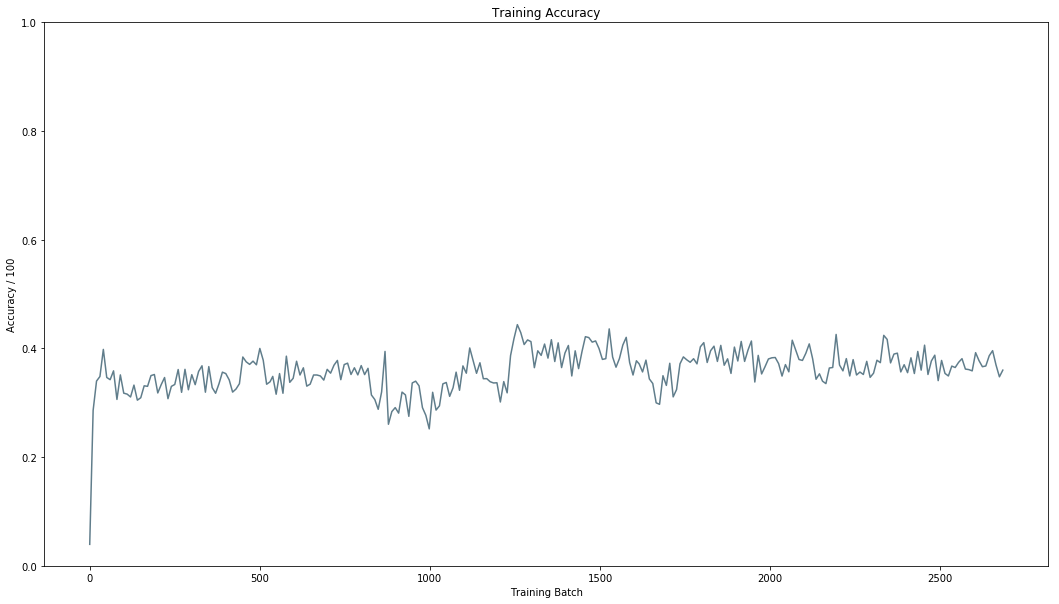

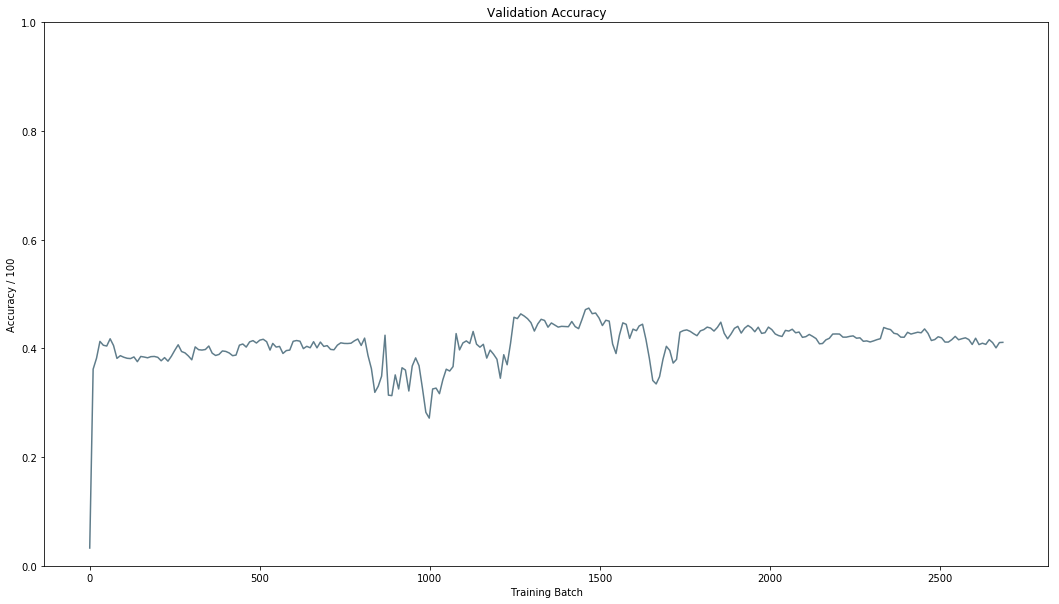

Mean validation accuracy in last ten samples is: 0.4099

Hyperparameters used:
RNN size: 128
Embedding size: 128

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 128
Embedding size = 256
Epoch   0 Batch    0/538 - Train Accuracy: 0.2383, Validation Accuracy: 0.3198, Loss: 5.8802
Epoch   0 Batch   10/538 - Train Accuracy: 0.3021, Validation Accuracy: 0.3833, Loss: 3.5234
Epoch   0 Batch   20/538 - Train Accuracy: 0.3629, Validation Accuracy: 0.4016, Loss: 3.0593
Epoch   0 Batch   30/538 - Train Accuracy: 0.3654, Validation Accuracy: 0.4196, Loss: 2.8681
Epoch   0 Batch   40/538 - Train Accuracy: 0.3429, Validation Accuracy: 0.3580, Loss: 2.4427
Epoch   0 Batch   50/538 - Train Accuracy: 0.2807, Validation Accuracy: 0.3477, Loss: 2.3957
Epoch   0 Batch   60/538 - Train Accuracy: 0.2600, Validation Accuracy: 0.3326, Loss: 2.3007
Epoch   0 Batch   70/538 - Train Accuracy: 0.2563, Validation Accuracy: 0.2910, Loss: 2.1556
Epoch   0 Batch

Epoch   1 Batch  320/538 - Train Accuracy: 0.1776, Validation Accuracy: 0.1864, Loss: 0.5777
Epoch   1 Batch  330/538 - Train Accuracy: 0.1834, Validation Accuracy: 0.1784, Loss: 0.5524
Epoch   1 Batch  340/538 - Train Accuracy: 0.1584, Validation Accuracy: 0.1667, Loss: 0.6098
Epoch   1 Batch  350/538 - Train Accuracy: 0.1882, Validation Accuracy: 0.1802, Loss: 0.5988
Epoch   1 Batch  360/538 - Train Accuracy: 0.1797, Validation Accuracy: 0.1758, Loss: 0.6054
Epoch   1 Batch  370/538 - Train Accuracy: 0.1900, Validation Accuracy: 0.2061, Loss: 0.5930
Epoch   1 Batch  380/538 - Train Accuracy: 0.1908, Validation Accuracy: 0.1992, Loss: 0.5635
Epoch   1 Batch  390/538 - Train Accuracy: 0.1715, Validation Accuracy: 0.1891, Loss: 0.5588
Epoch   1 Batch  400/538 - Train Accuracy: 0.1901, Validation Accuracy: 0.1939, Loss: 0.5460
Epoch   1 Batch  410/538 - Train Accuracy: 0.1926, Validation Accuracy: 0.1911, Loss: 0.5664
Epoch   1 Batch  420/538 - Train Accuracy: 0.1748, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.2115, Validation Accuracy: 0.2026, Loss: 0.3317
Epoch   3 Batch  140/538 - Train Accuracy: 0.1920, Validation Accuracy: 0.1905, Loss: 0.3865
Epoch   3 Batch  150/538 - Train Accuracy: 0.1922, Validation Accuracy: 0.1873, Loss: 0.3395
Epoch   3 Batch  160/538 - Train Accuracy: 0.1998, Validation Accuracy: 0.1871, Loss: 0.3336
Epoch   3 Batch  170/538 - Train Accuracy: 0.1840, Validation Accuracy: 0.1733, Loss: 0.3517
Epoch   3 Batch  180/538 - Train Accuracy: 0.2186, Validation Accuracy: 0.2088, Loss: 0.3417
Epoch   3 Batch  190/538 - Train Accuracy: 0.2076, Validation Accuracy: 0.1903, Loss: 0.3633
Epoch   3 Batch  200/538 - Train Accuracy: 0.2045, Validation Accuracy: 0.1919, Loss: 0.3413
Epoch   3 Batch  210/538 - Train Accuracy: 0.1892, Validation Accuracy: 0.1831, Loss: 0.3422
Epoch   3 Batch  220/538 - Train Accuracy: 0.1903, Validation Accuracy: 0.1843, Loss: 0.3338
Epoch   3 Batch  230/538 - Train Accuracy: 0.2129, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.2333, Validation Accuracy: 0.2379, Loss: 0.2755
Epoch   4 Batch  490/538 - Train Accuracy: 0.2480, Validation Accuracy: 0.2409, Loss: 0.2679
Epoch   4 Batch  500/538 - Train Accuracy: 0.2443, Validation Accuracy: 0.2377, Loss: 0.2453
Epoch   4 Batch  510/538 - Train Accuracy: 0.2413, Validation Accuracy: 0.2409, Loss: 0.2640
Epoch   4 Batch  520/538 - Train Accuracy: 0.2283, Validation Accuracy: 0.2344, Loss: 0.2831
Epoch   4 Batch  530/538 - Train Accuracy: 0.2270, Validation Accuracy: 0.2253, Loss: 0.2912


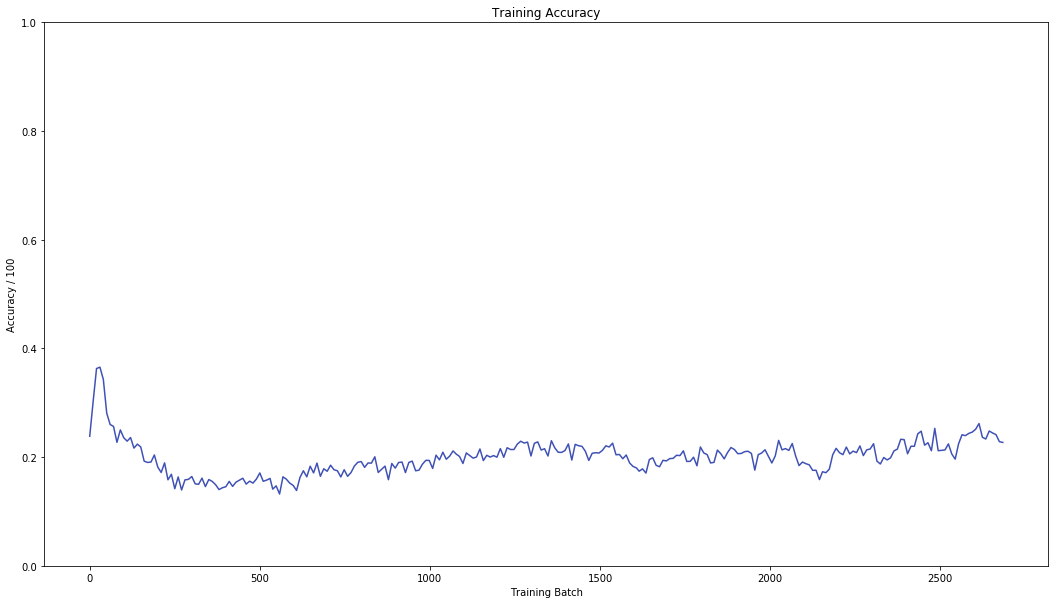

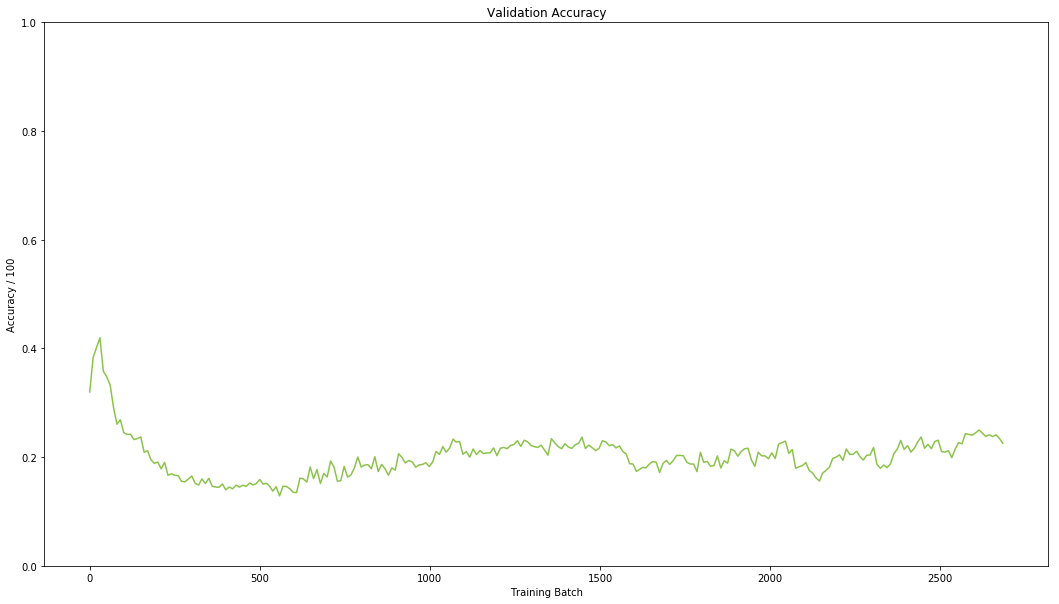

Mean validation accuracy in last ten samples is: 0.2396

Hyperparameters used:
RNN size: 128
Embedding size: 256

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 256
Embedding size = 64
Epoch   0 Batch    0/538 - Train Accuracy: 0.2402, Validation Accuracy: 0.3214, Loss: 5.8821
Epoch   0 Batch   10/538 - Train Accuracy: 0.3035, Validation Accuracy: 0.3810, Loss: 3.4633
Epoch   0 Batch   20/538 - Train Accuracy: 0.3590, Validation Accuracy: 0.3947, Loss: 3.0435
Epoch   0 Batch   30/538 - Train Accuracy: 0.3271, Validation Accuracy: 0.3912, Loss: 3.1271
Epoch   0 Batch   40/538 - Train Accuracy: 0.4052, Validation Accuracy: 0.4123, Loss: 2.7410
Epoch   0 Batch   50/538 - Train Accuracy: 0.3881, Validation Accuracy: 0.4395, Loss: 2.6944
Epoch   0 Batch   60/538 - Train Accuracy: 0.3018, Validation Accuracy: 0.3782, Loss: 2.5076
Epoch   0 Batch   70/538 - Train Accuracy: 0.2578, Validation Accuracy: 0.2853, Loss: 2.2650
Epoch   0 Batch 

Epoch   1 Batch  320/538 - Train Accuracy: 0.2346, Validation Accuracy: 0.2626, Loss: 0.5309
Epoch   1 Batch  330/538 - Train Accuracy: 0.2390, Validation Accuracy: 0.2521, Loss: 0.5128
Epoch   1 Batch  340/538 - Train Accuracy: 0.2010, Validation Accuracy: 0.2436, Loss: 0.5585
Epoch   1 Batch  350/538 - Train Accuracy: 0.2269, Validation Accuracy: 0.2553, Loss: 0.5287
Epoch   1 Batch  360/538 - Train Accuracy: 0.2176, Validation Accuracy: 0.2642, Loss: 0.5356
Epoch   1 Batch  370/538 - Train Accuracy: 0.2379, Validation Accuracy: 0.2846, Loss: 0.5400
Epoch   1 Batch  380/538 - Train Accuracy: 0.2156, Validation Accuracy: 0.2569, Loss: 0.5220
Epoch   1 Batch  390/538 - Train Accuracy: 0.1935, Validation Accuracy: 0.2285, Loss: 0.5103
Epoch   1 Batch  400/538 - Train Accuracy: 0.2284, Validation Accuracy: 0.2372, Loss: 0.5212
Epoch   1 Batch  410/538 - Train Accuracy: 0.2176, Validation Accuracy: 0.2241, Loss: 0.5330
Epoch   1 Batch  420/538 - Train Accuracy: 0.2176, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.2264, Validation Accuracy: 0.2299, Loss: 0.3493
Epoch   3 Batch  140/538 - Train Accuracy: 0.2453, Validation Accuracy: 0.2424, Loss: 0.3835
Epoch   3 Batch  150/538 - Train Accuracy: 0.2189, Validation Accuracy: 0.2427, Loss: 0.3645
Epoch   3 Batch  160/538 - Train Accuracy: 0.2770, Validation Accuracy: 0.2873, Loss: 0.3481
Epoch   3 Batch  170/538 - Train Accuracy: 0.2755, Validation Accuracy: 0.3018, Loss: 0.3531
Epoch   3 Batch  180/538 - Train Accuracy: 0.2887, Validation Accuracy: 0.3002, Loss: 0.3404
Epoch   3 Batch  190/538 - Train Accuracy: 0.2606, Validation Accuracy: 0.2676, Loss: 0.3560
Epoch   3 Batch  200/538 - Train Accuracy: 0.2500, Validation Accuracy: 0.2690, Loss: 0.3256
Epoch   3 Batch  210/538 - Train Accuracy: 0.2565, Validation Accuracy: 0.2601, Loss: 0.3286
Epoch   3 Batch  220/538 - Train Accuracy: 0.2777, Validation Accuracy: 0.2869, Loss: 0.3217
Epoch   3 Batch  230/538 - Train Accuracy: 0.2250, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.2958, Validation Accuracy: 0.2981, Loss: 0.2258
Epoch   4 Batch  490/538 - Train Accuracy: 0.2846, Validation Accuracy: 0.3020, Loss: 0.2288
Epoch   4 Batch  500/538 - Train Accuracy: 0.3379, Validation Accuracy: 0.3377, Loss: 0.2077
Epoch   4 Batch  510/538 - Train Accuracy: 0.2985, Validation Accuracy: 0.3081, Loss: 0.2233
Epoch   4 Batch  520/538 - Train Accuracy: 0.2734, Validation Accuracy: 0.3077, Loss: 0.2334
Epoch   4 Batch  530/538 - Train Accuracy: 0.2557, Validation Accuracy: 0.2828, Loss: 0.2321


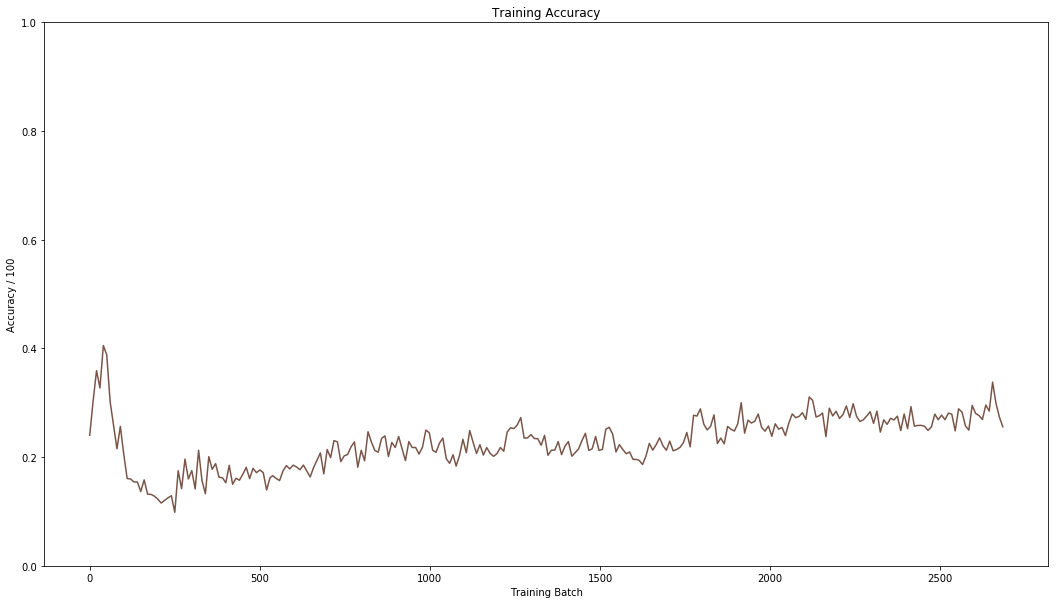

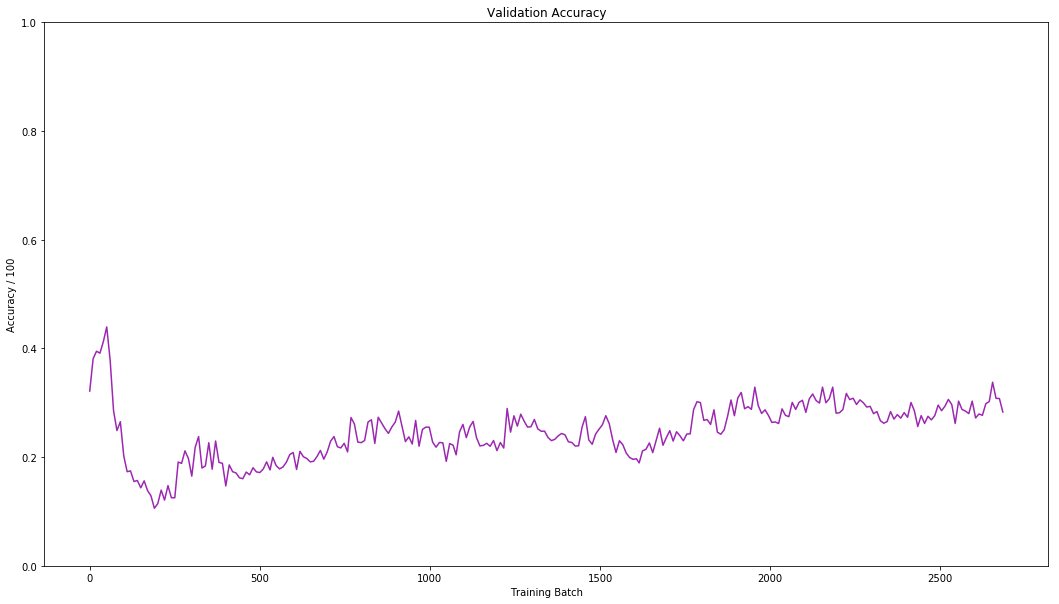

Mean validation accuracy in last ten samples is: 0.2968

Hyperparameters used:
RNN size: 256
Embedding size: 64

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 256
Embedding size = 128
Epoch   0 Batch    0/538 - Train Accuracy: 0.2354, Validation Accuracy: 0.3159, Loss: 5.8861
Epoch   0 Batch   10/538 - Train Accuracy: 0.3014, Validation Accuracy: 0.3773, Loss: 3.5420
Epoch   0 Batch   20/538 - Train Accuracy: 0.3787, Validation Accuracy: 0.4169, Loss: 2.9113
Epoch   0 Batch   30/538 - Train Accuracy: 0.3346, Validation Accuracy: 0.3910, Loss: 2.7220
Epoch   0 Batch   40/538 - Train Accuracy: 0.3082, Validation Accuracy: 0.3287, Loss: 2.1774
Epoch   0 Batch   50/538 - Train Accuracy: 0.2717, Validation Accuracy: 0.3150, Loss: 2.2087
Epoch   0 Batch   60/538 - Train Accuracy: 0.2527, Validation Accuracy: 0.2828, Loss: 1.9805
Epoch   0 Batch   70/538 - Train Accuracy: 0.2712, Validation Accuracy: 0.3176, Loss: 1.7329
Epoch   0 Batch 

Epoch   1 Batch  320/538 - Train Accuracy: 0.2703, Validation Accuracy: 0.2784, Loss: 0.5122
Epoch   1 Batch  330/538 - Train Accuracy: 0.2759, Validation Accuracy: 0.2646, Loss: 0.5284
Epoch   1 Batch  340/538 - Train Accuracy: 0.2502, Validation Accuracy: 0.2827, Loss: 0.5482
Epoch   1 Batch  350/538 - Train Accuracy: 0.2699, Validation Accuracy: 0.2738, Loss: 0.5315
Epoch   1 Batch  360/538 - Train Accuracy: 0.2588, Validation Accuracy: 0.2653, Loss: 0.5302
Epoch   1 Batch  370/538 - Train Accuracy: 0.2658, Validation Accuracy: 0.2670, Loss: 0.5359
Epoch   1 Batch  380/538 - Train Accuracy: 0.2586, Validation Accuracy: 0.2502, Loss: 0.5076
Epoch   1 Batch  390/538 - Train Accuracy: 0.2520, Validation Accuracy: 0.2617, Loss: 0.4967
Epoch   1 Batch  400/538 - Train Accuracy: 0.2595, Validation Accuracy: 0.2624, Loss: 0.4958
Epoch   1 Batch  410/538 - Train Accuracy: 0.2740, Validation Accuracy: 0.2662, Loss: 0.5110
Epoch   1 Batch  420/538 - Train Accuracy: 0.2436, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.3534, Validation Accuracy: 0.3786, Loss: 0.3527
Epoch   3 Batch  140/538 - Train Accuracy: 0.3219, Validation Accuracy: 0.3677, Loss: 0.3834
Epoch   3 Batch  150/538 - Train Accuracy: 0.3529, Validation Accuracy: 0.3807, Loss: 0.3647
Epoch   3 Batch  160/538 - Train Accuracy: 0.3438, Validation Accuracy: 0.3706, Loss: 0.3473
Epoch   3 Batch  170/538 - Train Accuracy: 0.3190, Validation Accuracy: 0.3519, Loss: 0.3647
Epoch   3 Batch  180/538 - Train Accuracy: 0.3155, Validation Accuracy: 0.3606, Loss: 0.3503
Epoch   3 Batch  190/538 - Train Accuracy: 0.3493, Validation Accuracy: 0.3809, Loss: 0.3662
Epoch   3 Batch  200/538 - Train Accuracy: 0.3213, Validation Accuracy: 0.3764, Loss: 0.3543
Epoch   3 Batch  210/538 - Train Accuracy: 0.3477, Validation Accuracy: 0.3610, Loss: 0.3534
Epoch   3 Batch  220/538 - Train Accuracy: 0.3439, Validation Accuracy: 0.3707, Loss: 0.3360
Epoch   3 Batch  230/538 - Train Accuracy: 0.3143, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.2695, Validation Accuracy: 0.2841, Loss: 0.2215
Epoch   4 Batch  490/538 - Train Accuracy: 0.2939, Validation Accuracy: 0.2860, Loss: 0.2259
Epoch   4 Batch  500/538 - Train Accuracy: 0.3301, Validation Accuracy: 0.3074, Loss: 0.1984
Epoch   4 Batch  510/538 - Train Accuracy: 0.3110, Validation Accuracy: 0.3079, Loss: 0.2265
Epoch   4 Batch  520/538 - Train Accuracy: 0.3176, Validation Accuracy: 0.3223, Loss: 0.2235
Epoch   4 Batch  530/538 - Train Accuracy: 0.3217, Validation Accuracy: 0.3212, Loss: 0.2334


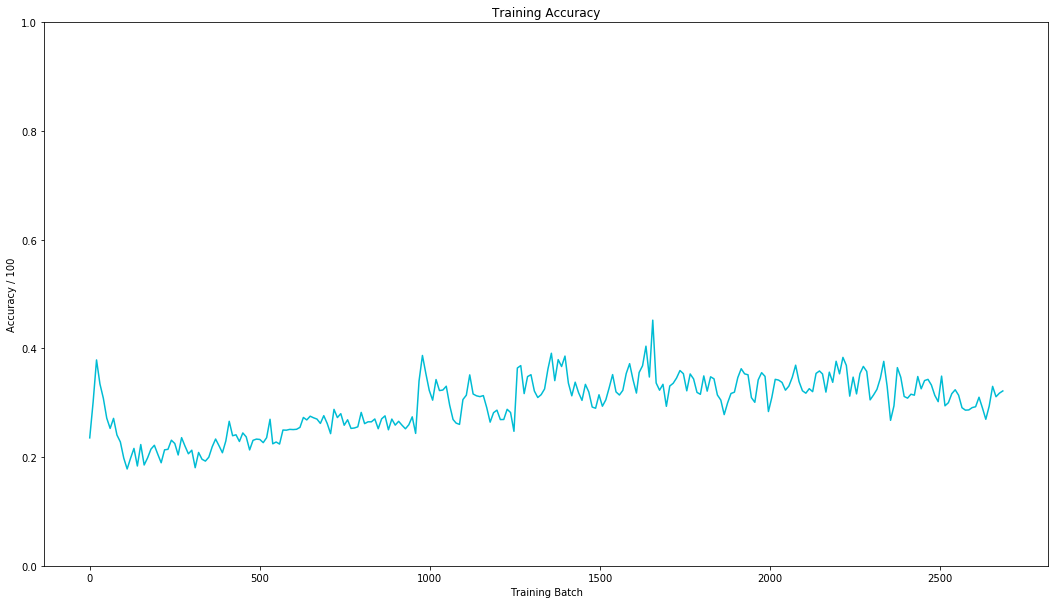

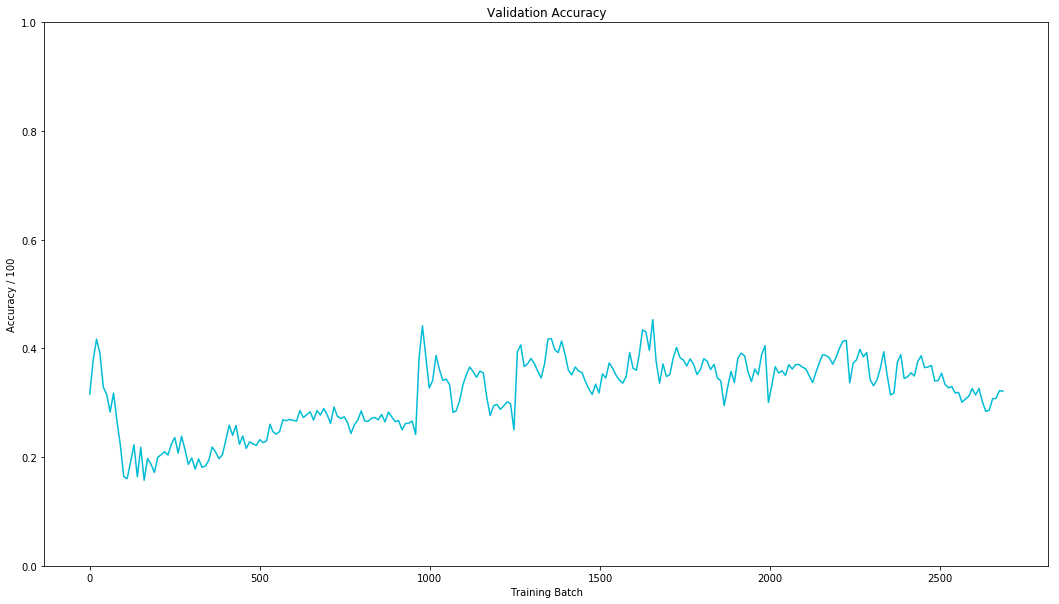

Mean validation accuracy in last ten samples is: 0.3097

Hyperparameters used:
RNN size: 256
Embedding size: 128

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 256
Embedding size = 256
Epoch   0 Batch    0/538 - Train Accuracy: 0.2029, Validation Accuracy: 0.2369, Loss: 5.8914
Epoch   0 Batch   10/538 - Train Accuracy: 0.2971, Validation Accuracy: 0.3764, Loss: 3.4950
Epoch   0 Batch   20/538 - Train Accuracy: 0.3443, Validation Accuracy: 0.3857, Loss: 3.0747
Epoch   0 Batch   30/538 - Train Accuracy: 0.3312, Validation Accuracy: 0.3960, Loss: 3.0411
Epoch   0 Batch   40/538 - Train Accuracy: 0.4151, Validation Accuracy: 0.4126, Loss: 2.5351
Epoch   0 Batch   50/538 - Train Accuracy: 0.2775, Validation Accuracy: 0.3301, Loss: 2.4977
Epoch   0 Batch   60/538 - Train Accuracy: 0.1994, Validation Accuracy: 0.2575, Loss: 2.3121
Epoch   0 Batch   70/538 - Train Accuracy: 0.1988, Validation Accuracy: 0.2198, Loss: 2.1742
Epoch   0 Batch

Epoch   1 Batch  320/538 - Train Accuracy: 0.1170, Validation Accuracy: 0.1113, Loss: 0.5023
Epoch   1 Batch  330/538 - Train Accuracy: 0.1254, Validation Accuracy: 0.1040, Loss: 0.4981
Epoch   1 Batch  340/538 - Train Accuracy: 0.1150, Validation Accuracy: 0.1042, Loss: 0.5377
Epoch   1 Batch  350/538 - Train Accuracy: 0.0991, Validation Accuracy: 0.0982, Loss: 0.4958
Epoch   1 Batch  360/538 - Train Accuracy: 0.1242, Validation Accuracy: 0.1152, Loss: 0.5143
Epoch   1 Batch  370/538 - Train Accuracy: 0.1285, Validation Accuracy: 0.0989, Loss: 0.5153
Epoch   1 Batch  380/538 - Train Accuracy: 0.1061, Validation Accuracy: 0.0893, Loss: 0.4990
Epoch   1 Batch  390/538 - Train Accuracy: 0.1233, Validation Accuracy: 0.1273, Loss: 0.4875
Epoch   1 Batch  400/538 - Train Accuracy: 0.1049, Validation Accuracy: 0.0929, Loss: 0.4878
Epoch   1 Batch  410/538 - Train Accuracy: 0.1119, Validation Accuracy: 0.0877, Loss: 0.4931
Epoch   1 Batch  420/538 - Train Accuracy: 0.0908, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.2253, Validation Accuracy: 0.2445, Loss: 0.2696
Epoch   3 Batch  140/538 - Train Accuracy: 0.2143, Validation Accuracy: 0.2221, Loss: 0.3086
Epoch   3 Batch  150/538 - Train Accuracy: 0.1953, Validation Accuracy: 0.2060, Loss: 0.2734
Epoch   3 Batch  160/538 - Train Accuracy: 0.2057, Validation Accuracy: 0.2140, Loss: 0.2703
Epoch   3 Batch  170/538 - Train Accuracy: 0.1842, Validation Accuracy: 0.1886, Loss: 0.2716
Epoch   3 Batch  180/538 - Train Accuracy: 0.1888, Validation Accuracy: 0.1916, Loss: 0.2725
Epoch   3 Batch  190/538 - Train Accuracy: 0.1823, Validation Accuracy: 0.1909, Loss: 0.2792
Epoch   3 Batch  200/538 - Train Accuracy: 0.1857, Validation Accuracy: 0.1923, Loss: 0.2629
Epoch   3 Batch  210/538 - Train Accuracy: 0.1843, Validation Accuracy: 0.2063, Loss: 0.2594
Epoch   3 Batch  220/538 - Train Accuracy: 0.2327, Validation Accuracy: 0.2191, Loss: 0.2455
Epoch   3 Batch  230/538 - Train Accuracy: 0.2268, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.2533, Validation Accuracy: 0.2752, Loss: 0.1384
Epoch   4 Batch  490/538 - Train Accuracy: 0.2725, Validation Accuracy: 0.3010, Loss: 0.1457
Epoch   4 Batch  500/538 - Train Accuracy: 0.2836, Validation Accuracy: 0.2953, Loss: 0.1216
Epoch   4 Batch  510/538 - Train Accuracy: 0.2305, Validation Accuracy: 0.2566, Loss: 0.1410
Epoch   4 Batch  520/538 - Train Accuracy: 0.2213, Validation Accuracy: 0.2619, Loss: 0.1468
Epoch   4 Batch  530/538 - Train Accuracy: 0.2396, Validation Accuracy: 0.2594, Loss: 0.1426


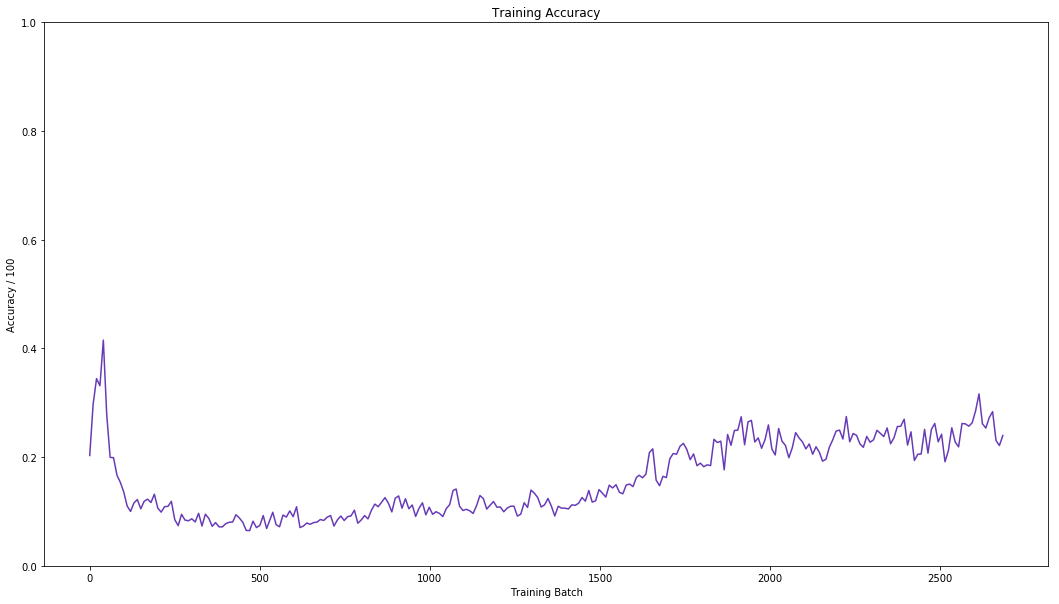

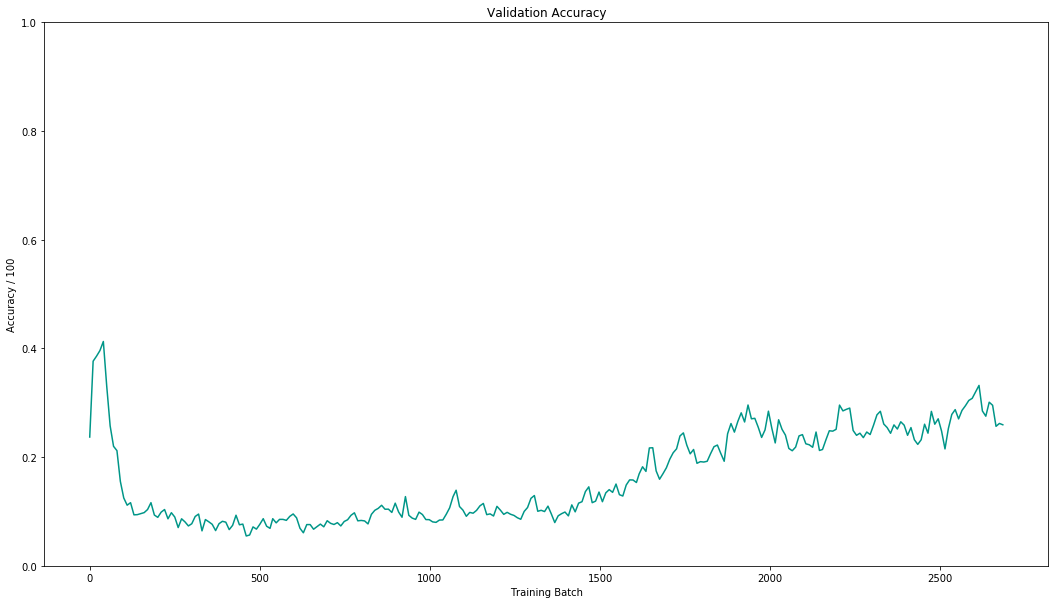

Mean validation accuracy in last ten samples is: 0.2894

Hyperparameters used:
RNN size: 256
Embedding size: 256

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 512
Embedding size = 64
Epoch   0 Batch    0/538 - Train Accuracy: 0.2373, Validation Accuracy: 0.3180, Loss: 6.0235
Epoch   0 Batch   10/538 - Train Accuracy: 0.3066, Validation Accuracy: 0.3867, Loss: 3.5103
Epoch   0 Batch   20/538 - Train Accuracy: 0.3536, Validation Accuracy: 0.3903, Loss: 3.0466
Epoch   0 Batch   30/538 - Train Accuracy: 0.3330, Validation Accuracy: 0.3960, Loss: 3.0769
Epoch   0 Batch   40/538 - Train Accuracy: 0.3901, Validation Accuracy: 0.3972, Loss: 2.6978
Epoch   0 Batch   50/538 - Train Accuracy: 0.3314, Validation Accuracy: 0.3892, Loss: 2.8507
Epoch   0 Batch   60/538 - Train Accuracy: 0.3381, Validation Accuracy: 0.4034, Loss: 2.8219
Epoch   0 Batch   70/538 - Train Accuracy: 0.3659, Validation Accuracy: 0.4020, Loss: 2.6756
Epoch   0 Batch 

Epoch   1 Batch  320/538 - Train Accuracy: 0.1382, Validation Accuracy: 0.1309, Loss: 0.6310
Epoch   1 Batch  330/538 - Train Accuracy: 0.1315, Validation Accuracy: 0.1202, Loss: 0.6178
Epoch   1 Batch  340/538 - Train Accuracy: 0.1488, Validation Accuracy: 0.1252, Loss: 0.6751
Epoch   1 Batch  350/538 - Train Accuracy: 0.1397, Validation Accuracy: 0.1262, Loss: 0.6471
Epoch   1 Batch  360/538 - Train Accuracy: 0.1453, Validation Accuracy: 0.1273, Loss: 0.6483
Epoch   1 Batch  370/538 - Train Accuracy: 0.1385, Validation Accuracy: 0.1206, Loss: 0.6493
Epoch   1 Batch  380/538 - Train Accuracy: 0.1336, Validation Accuracy: 0.1229, Loss: 0.6255
Epoch   1 Batch  390/538 - Train Accuracy: 0.1347, Validation Accuracy: 0.1183, Loss: 0.6249
Epoch   1 Batch  400/538 - Train Accuracy: 0.1443, Validation Accuracy: 0.1291, Loss: 0.6104
Epoch   1 Batch  410/538 - Train Accuracy: 0.1408, Validation Accuracy: 0.1310, Loss: 0.6412
Epoch   1 Batch  420/538 - Train Accuracy: 0.1533, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.1585, Validation Accuracy: 0.1458, Loss: 0.5357
Epoch   3 Batch  140/538 - Train Accuracy: 0.1670, Validation Accuracy: 0.1490, Loss: 0.5783
Epoch   3 Batch  150/538 - Train Accuracy: 0.1623, Validation Accuracy: 0.1460, Loss: 0.5570
Epoch   3 Batch  160/538 - Train Accuracy: 0.1536, Validation Accuracy: 0.1367, Loss: 0.5414
Epoch   3 Batch  170/538 - Train Accuracy: 0.1529, Validation Accuracy: 0.1412, Loss: 0.5449
Epoch   3 Batch  180/538 - Train Accuracy: 0.1592, Validation Accuracy: 0.1399, Loss: 0.5300
Epoch   3 Batch  190/538 - Train Accuracy: 0.1546, Validation Accuracy: 0.1429, Loss: 0.5397
Epoch   3 Batch  200/538 - Train Accuracy: 0.1590, Validation Accuracy: 0.1373, Loss: 0.5319
Epoch   3 Batch  210/538 - Train Accuracy: 0.1509, Validation Accuracy: 0.1461, Loss: 0.5401
Epoch   3 Batch  220/538 - Train Accuracy: 0.1544, Validation Accuracy: 0.1500, Loss: 0.5165
Epoch   3 Batch  230/538 - Train Accuracy: 0.1533, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.2013, Validation Accuracy: 0.1696, Loss: 0.4780
Epoch   4 Batch  490/538 - Train Accuracy: 0.1948, Validation Accuracy: 0.1726, Loss: 0.4934
Epoch   4 Batch  500/538 - Train Accuracy: 0.1792, Validation Accuracy: 0.1612, Loss: 0.4413
Epoch   4 Batch  510/538 - Train Accuracy: 0.1935, Validation Accuracy: 0.1717, Loss: 0.4908
Epoch   4 Batch  520/538 - Train Accuracy: 0.2014, Validation Accuracy: 0.1713, Loss: 0.4922
Epoch   4 Batch  530/538 - Train Accuracy: 0.1947, Validation Accuracy: 0.1699, Loss: 0.4975


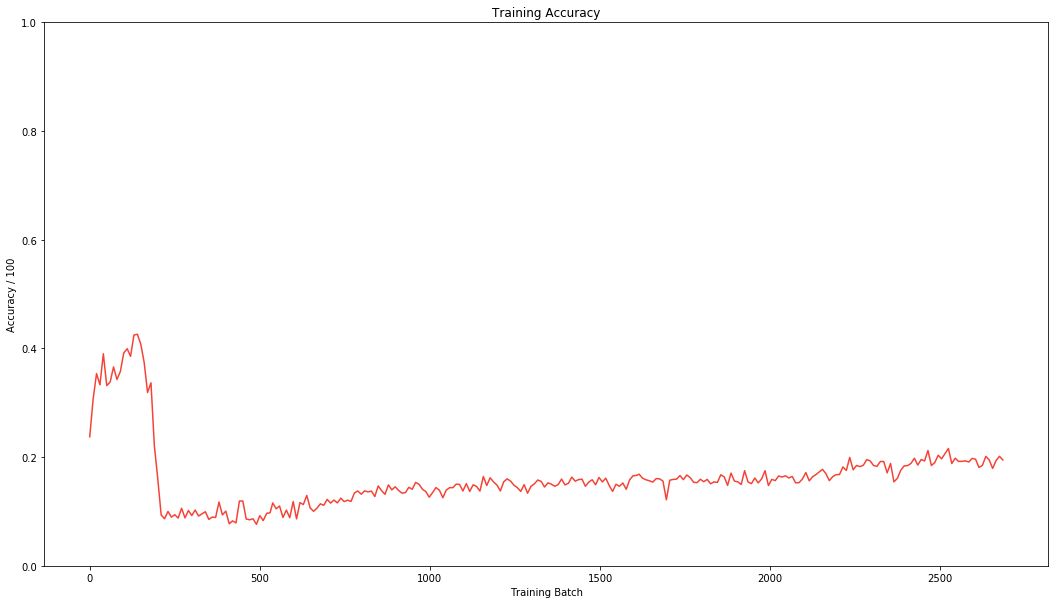

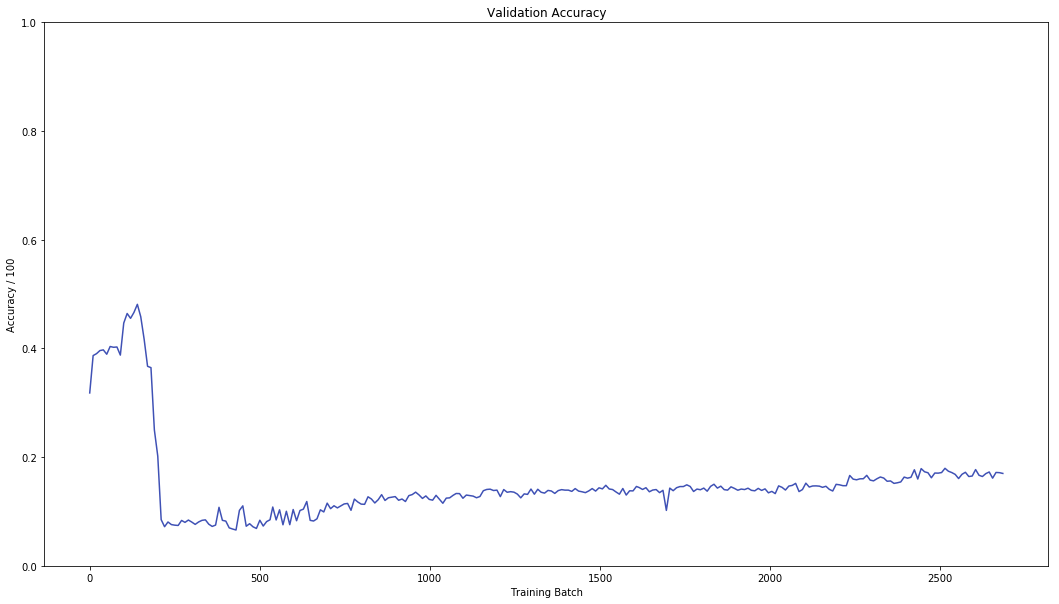

Mean validation accuracy in last ten samples is: 0.1689

Hyperparameters used:
RNN size: 512
Embedding size: 64

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 512
Embedding size = 128
Epoch   0 Batch    0/538 - Train Accuracy: 0.2709, Validation Accuracy: 0.3459, Loss: 5.9646
Epoch   0 Batch   10/538 - Train Accuracy: 0.3002, Validation Accuracy: 0.3784, Loss: 3.5418
Epoch   0 Batch   20/538 - Train Accuracy: 0.3445, Validation Accuracy: 0.3789, Loss: 3.0434
Epoch   0 Batch   30/538 - Train Accuracy: 0.3279, Validation Accuracy: 0.3972, Loss: 3.0370
Epoch   0 Batch   40/538 - Train Accuracy: 0.3830, Validation Accuracy: 0.3876, Loss: 2.6745
Epoch   0 Batch   50/538 - Train Accuracy: 0.3543, Validation Accuracy: 0.4071, Loss: 2.7970
Epoch   0 Batch   60/538 - Train Accuracy: 0.3607, Validation Accuracy: 0.4242, Loss: 2.6296
Epoch   0 Batch   70/538 - Train Accuracy: 0.3581, Validation Accuracy: 0.3977, Loss: 2.7056
Epoch   0 Batch 

Epoch   1 Batch  320/538 - Train Accuracy: 0.0990, Validation Accuracy: 0.0895, Loss: 0.6468
Epoch   1 Batch  330/538 - Train Accuracy: 0.1004, Validation Accuracy: 0.0973, Loss: 0.6299
Epoch   1 Batch  340/538 - Train Accuracy: 0.1057, Validation Accuracy: 0.0957, Loss: 0.6905
Epoch   1 Batch  350/538 - Train Accuracy: 0.0952, Validation Accuracy: 0.0938, Loss: 0.6430
Epoch   1 Batch  360/538 - Train Accuracy: 0.1084, Validation Accuracy: 0.0927, Loss: 0.6690
Epoch   1 Batch  370/538 - Train Accuracy: 0.1152, Validation Accuracy: 0.1028, Loss: 0.6729
Epoch   1 Batch  380/538 - Train Accuracy: 0.1205, Validation Accuracy: 0.1065, Loss: 0.6591
Epoch   1 Batch  390/538 - Train Accuracy: 0.1241, Validation Accuracy: 0.1120, Loss: 0.6414
Epoch   1 Batch  400/538 - Train Accuracy: 0.1205, Validation Accuracy: 0.1170, Loss: 0.6238
Epoch   1 Batch  410/538 - Train Accuracy: 0.1248, Validation Accuracy: 0.1072, Loss: 0.6542
Epoch   1 Batch  420/538 - Train Accuracy: 0.1225, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.1583, Validation Accuracy: 0.1417, Loss: 0.5217
Epoch   3 Batch  140/538 - Train Accuracy: 0.1654, Validation Accuracy: 0.1456, Loss: 0.5564
Epoch   3 Batch  150/538 - Train Accuracy: 0.1641, Validation Accuracy: 0.1456, Loss: 0.5399
Epoch   3 Batch  160/538 - Train Accuracy: 0.1570, Validation Accuracy: 0.1399, Loss: 0.5239
Epoch   3 Batch  170/538 - Train Accuracy: 0.1562, Validation Accuracy: 0.1438, Loss: 0.5233
Epoch   3 Batch  180/538 - Train Accuracy: 0.1557, Validation Accuracy: 0.1431, Loss: 0.5187
Epoch   3 Batch  190/538 - Train Accuracy: 0.1525, Validation Accuracy: 0.1454, Loss: 0.5141
Epoch   3 Batch  200/538 - Train Accuracy: 0.1572, Validation Accuracy: 0.1438, Loss: 0.5254
Epoch   3 Batch  210/538 - Train Accuracy: 0.1464, Validation Accuracy: 0.1444, Loss: 0.5252
Epoch   3 Batch  220/538 - Train Accuracy: 0.1536, Validation Accuracy: 0.1429, Loss: 0.5010
Epoch   3 Batch  230/538 - Train Accuracy: 0.1521, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.1669, Validation Accuracy: 0.1555, Loss: 0.3618
Epoch   4 Batch  490/538 - Train Accuracy: 0.1600, Validation Accuracy: 0.1543, Loss: 0.3747
Epoch   4 Batch  500/538 - Train Accuracy: 0.1532, Validation Accuracy: 0.1493, Loss: 0.3262
Epoch   4 Batch  510/538 - Train Accuracy: 0.1585, Validation Accuracy: 0.1520, Loss: 0.3610
Epoch   4 Batch  520/538 - Train Accuracy: 0.1666, Validation Accuracy: 0.1522, Loss: 0.3737
Epoch   4 Batch  530/538 - Train Accuracy: 0.1740, Validation Accuracy: 0.1523, Loss: 0.3746


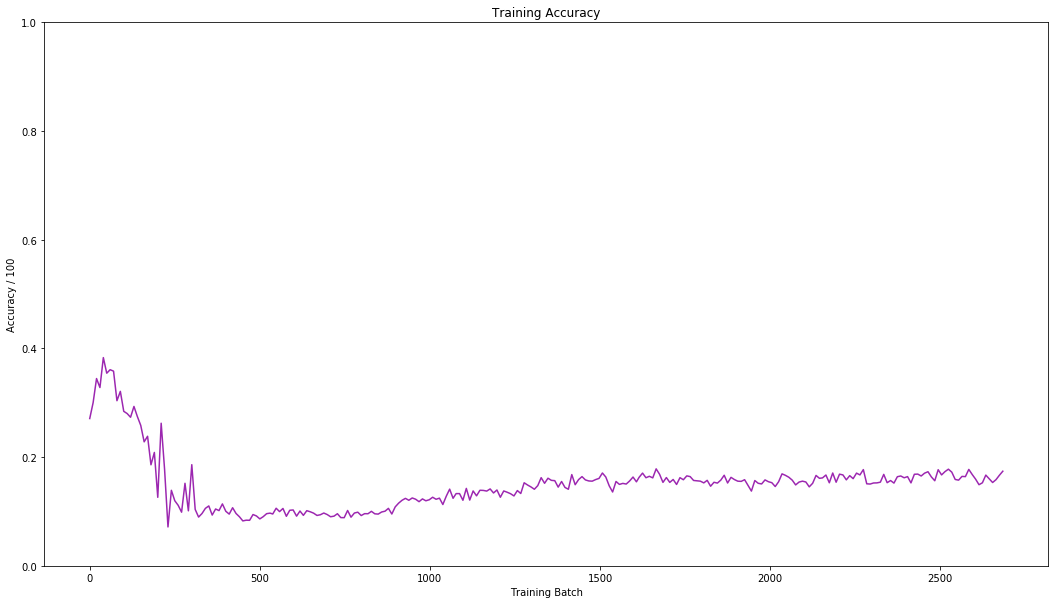

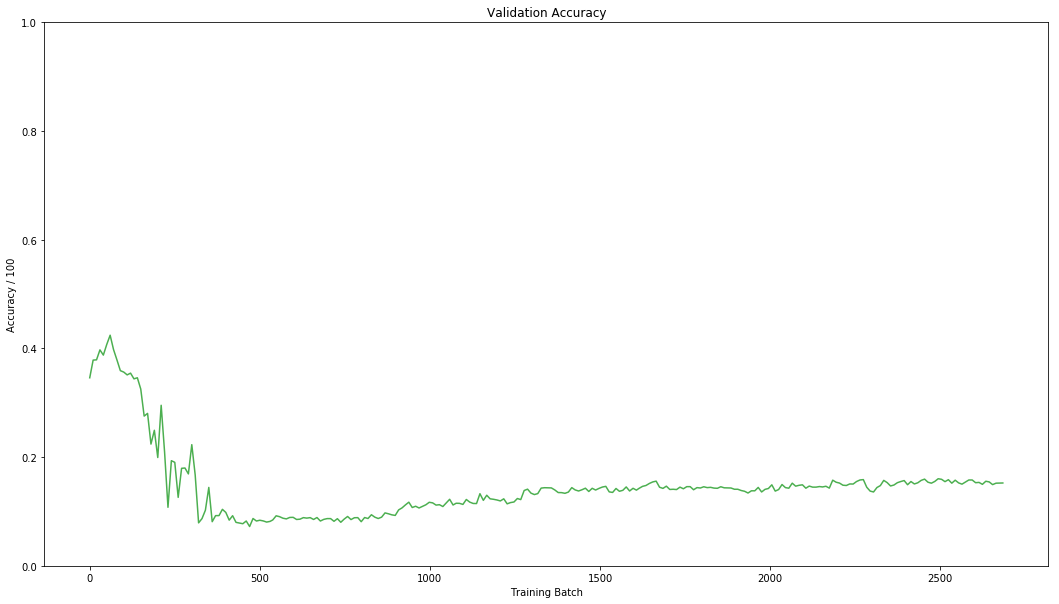

Mean validation accuracy in last ten samples is: 0.1530

Hyperparameters used:
RNN size: 512
Embedding size: 128

Model Trained and Saved
--------------------------------------------

New hyperparameters:
RNN size = 512
Embedding size = 256
Epoch   0 Batch    0/538 - Train Accuracy: 0.0695, Validation Accuracy: 0.1016, Loss: 5.9140
Epoch   0 Batch   10/538 - Train Accuracy: 0.2695, Validation Accuracy: 0.3533, Loss: 3.6609
Epoch   0 Batch   20/538 - Train Accuracy: 0.3443, Validation Accuracy: 0.3857, Loss: 3.1160
Epoch   0 Batch   30/538 - Train Accuracy: 0.3311, Validation Accuracy: 0.3986, Loss: 3.1032
Epoch   0 Batch   40/538 - Train Accuracy: 0.3784, Validation Accuracy: 0.3816, Loss: 2.6884
Epoch   0 Batch   50/538 - Train Accuracy: 0.3303, Validation Accuracy: 0.3857, Loss: 2.7105
Epoch   0 Batch   60/538 - Train Accuracy: 0.3242, Validation Accuracy: 0.3768, Loss: 2.5659
Epoch   0 Batch   70/538 - Train Accuracy: 0.3015, Validation Accuracy: 0.3288, Loss: 2.3708
Epoch   0 Batch

Epoch   1 Batch  320/538 - Train Accuracy: 0.1698, Validation Accuracy: 0.1557, Loss: 0.5225
Epoch   1 Batch  330/538 - Train Accuracy: 0.1607, Validation Accuracy: 0.1532, Loss: 0.5161
Epoch   1 Batch  340/538 - Train Accuracy: 0.1621, Validation Accuracy: 0.1470, Loss: 0.5649
Epoch   1 Batch  350/538 - Train Accuracy: 0.1654, Validation Accuracy: 0.1515, Loss: 0.5347
Epoch   1 Batch  360/538 - Train Accuracy: 0.1678, Validation Accuracy: 0.1420, Loss: 0.5439
Epoch   1 Batch  370/538 - Train Accuracy: 0.1695, Validation Accuracy: 0.1497, Loss: 0.5431
Epoch   1 Batch  380/538 - Train Accuracy: 0.1631, Validation Accuracy: 0.1582, Loss: 0.5250
Epoch   1 Batch  390/538 - Train Accuracy: 0.1730, Validation Accuracy: 0.1525, Loss: 0.5186
Epoch   1 Batch  400/538 - Train Accuracy: 0.1549, Validation Accuracy: 0.1458, Loss: 0.5130
Epoch   1 Batch  410/538 - Train Accuracy: 0.1584, Validation Accuracy: 0.1470, Loss: 0.5367
Epoch   1 Batch  420/538 - Train Accuracy: 0.1723, Validation Accuracy

Epoch   3 Batch  130/538 - Train Accuracy: 0.1866, Validation Accuracy: 0.1845, Loss: 0.3539
Epoch   3 Batch  140/538 - Train Accuracy: 0.2111, Validation Accuracy: 0.1875, Loss: 0.3664
Epoch   3 Batch  150/538 - Train Accuracy: 0.2104, Validation Accuracy: 0.1834, Loss: 0.3535
Epoch   3 Batch  160/538 - Train Accuracy: 0.2054, Validation Accuracy: 0.1879, Loss: 0.3469
Epoch   3 Batch  170/538 - Train Accuracy: 0.2050, Validation Accuracy: 0.1879, Loss: 0.3383
Epoch   3 Batch  180/538 - Train Accuracy: 0.1948, Validation Accuracy: 0.1816, Loss: 0.3329
Epoch   3 Batch  190/538 - Train Accuracy: 0.1907, Validation Accuracy: 0.1895, Loss: 0.3431
Epoch   3 Batch  200/538 - Train Accuracy: 0.2092, Validation Accuracy: 0.1838, Loss: 0.3215
Epoch   3 Batch  210/538 - Train Accuracy: 0.1974, Validation Accuracy: 0.1870, Loss: 0.3272
Epoch   3 Batch  220/538 - Train Accuracy: 0.2007, Validation Accuracy: 0.1893, Loss: 0.3331
Epoch   3 Batch  230/538 - Train Accuracy: 0.2027, Validation Accuracy

Epoch   4 Batch  480/538 - Train Accuracy: 0.2093, Validation Accuracy: 0.1969, Loss: 0.1979
Epoch   4 Batch  490/538 - Train Accuracy: 0.2186, Validation Accuracy: 0.2005, Loss: 0.1948
Epoch   4 Batch  500/538 - Train Accuracy: 0.2154, Validation Accuracy: 0.2051, Loss: 0.1839
Epoch   4 Batch  510/538 - Train Accuracy: 0.2132, Validation Accuracy: 0.2044, Loss: 0.1878
Epoch   4 Batch  520/538 - Train Accuracy: 0.2277, Validation Accuracy: 0.2095, Loss: 0.1989
Epoch   4 Batch  530/538 - Train Accuracy: 0.2262, Validation Accuracy: 0.2042, Loss: 0.2113


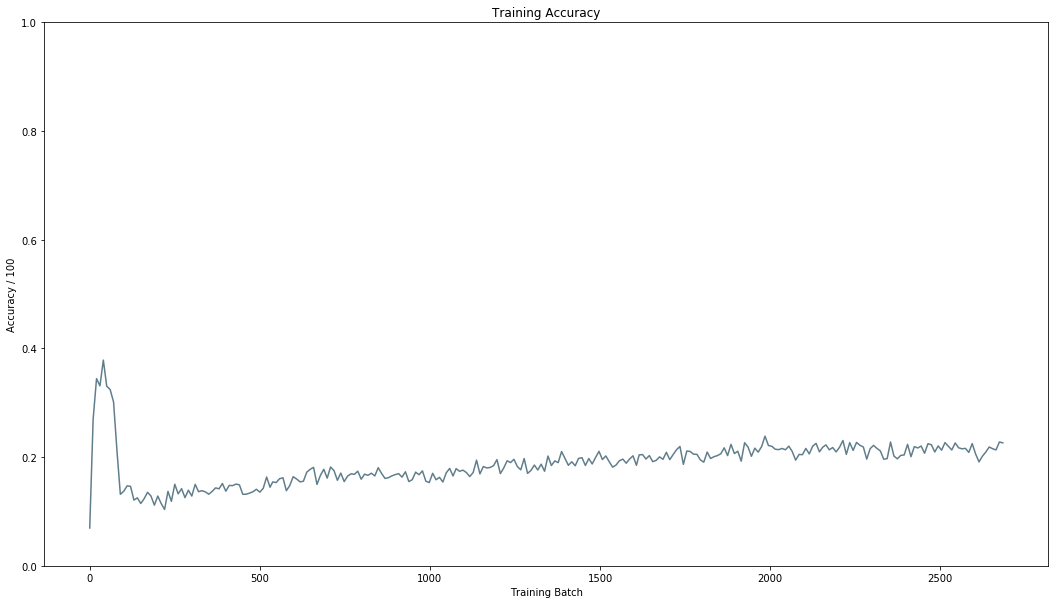

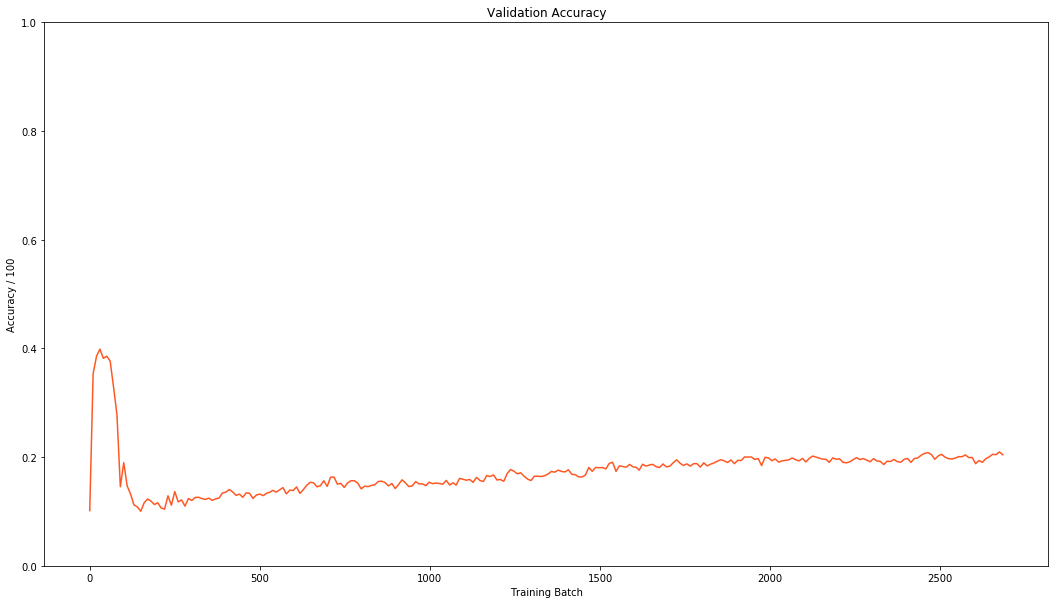

Mean validation accuracy in last ten samples is: 0.1992

Hyperparameters used:
RNN size: 512
Embedding size: 256

Model Trained and Saved
--------------------------------------------



In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))
# Number of Epochs
epochs = 5
# RNN Size
rnn_size_set = [64, 128, 256, 512]
# Number of Layers
num_layers = 4
# Embedding Size
embedding_size_set = [64, 128, 256]
# Learning Rate
learning_rate = 0.005
# Dropout Keep Probability
keep_probability = 0.5
display_step = 10

# Plot settings
plot_num = 0
plot_colors = ['#f44336', '#E91E63', '#9C27B0', '#673AB7', '#3F51B5', '#2196F3', 
               '#03A9F4', '#00BCD4', '#009688', '#4CAF50', '#8BC34A', '#FFC107', 
               '#FF9800', '#FF5722', '#795548', '#9E9E9E', '#607D8B']


# Grid search hyperparameters
for rnn_size in rnn_size_set:
    for encoding_embedding_size in embedding_size_set:
        
        # Print the new hyperparameters
        print('New hyperparameters:')
        print('RNN size = ' + str(rnn_size))
        print('Embedding size = ' + str(encoding_embedding_size))
        
        # Initialize the plot data vectors
        batch_plot = []
        training_acc_plot = []
        validation_acc_plot = []
        plot_num = 0
        
        # Build the graph ----------------------------------------------------------------------------
        save_path = 'checkpoints/dev'
        (source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
        max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

        train_graph = tf.Graph()
        with train_graph.as_default():
            input_data, targets, lr, keep_prob, target_sequence_length, max_target_sequence_length, source_sequence_length = model_inputs()

            #sequence_length = tf.placeholder_with_default(max_target_sentence_length, None, name='sequence_length')
            input_shape = tf.shape(input_data)

            train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                           targets,
                                                           keep_prob,
                                                           batch_size,
                                                           source_sequence_length,
                                                           target_sequence_length,
                                                           max_target_sequence_length,
                                                           len(source_vocab_to_int),
                                                           len(target_vocab_to_int),
                                                           encoding_embedding_size,
                                                           encoding_embedding_size,
                                                           rnn_size,
                                                           num_layers,
                                                           target_vocab_to_int)


            training_logits = tf.identity(train_logits.rnn_output, name='logits')
            inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

            masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

            with tf.name_scope("optimization"):
                # Loss function
                cost = tf.contrib.seq2seq.sequence_loss(
                    training_logits,
                    targets,
                    masks)

                # Optimizer
                optimizer = tf.train.AdamOptimizer(lr)

                # Gradient Clipping
                gradients = optimizer.compute_gradients(cost)
                capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
                train_op = optimizer.apply_gradients(capped_gradients)
        
        
        
        
        # Do the training ----------------------------------------------------------------------------
        with tf.Session(graph=train_graph) as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_i in range(epochs):        
                for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                        get_batches(train_source, train_target, batch_size,
                                    source_vocab_to_int['<PAD>'],
                                    target_vocab_to_int['<PAD>'])):

                    _, loss = sess.run(
                        [train_op, cost],
                        {input_data: source_batch,
                         targets: target_batch,
                         lr: learning_rate,
                         target_sequence_length: targets_lengths,
                         source_sequence_length: sources_lengths,
                         keep_prob: keep_probability})


                    if batch_i % display_step == 0 or batch_i == (len(source_int_text) // batch_size):


                        batch_train_logits = sess.run(
                            inference_logits,
                            {input_data: source_batch,
                             source_sequence_length: sources_lengths,
                             target_sequence_length: targets_lengths,
                             keep_prob: 1.0})


                        batch_valid_logits = sess.run(
                            inference_logits,
                            {input_data: valid_sources_batch,
                             source_sequence_length: valid_sources_lengths,
                             target_sequence_length: valid_targets_lengths,
                             keep_prob: 1.0})

                        train_acc = get_accuracy(target_batch, batch_train_logits)

                        valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                        print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                              .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

                        # Save the accuracy data for plotting
                        batch_plot.append((epoch_i * len(source_int_text) // batch_size) + batch_i)
                        training_acc_plot.append(train_acc)
                        validation_acc_plot.append(valid_acc)

            # Create the plots
            plt.figure(plot_num * 2)
            plt.plot(batch_plot, training_acc_plot, color=random.choice(plot_colors))
            plt.ylim(0, 1.0)
            plt.title('Training Accuracy')
            plt.xlabel('Training Batch')
            plt.ylabel('Accuracy / 100')
            plt.rcParams["figure.figsize"] = [18, 10]
            plt.figure(plot_num * 2 + 1)
            plt.plot(batch_plot, validation_acc_plot, color=random.choice(plot_colors))
            plt.ylim(0, 1.0)
            plt.title('Validation Accuracy')
            plt.xlabel('Training Batch')
            plt.ylabel('Accuracy / 100')
            plt.rcParams["figure.figsize"] = [18, 10]
            plt.show()
            
            # Reprint the hyperparameters and display the accuracy info
            print('Mean validation accuracy in last ten samples is: {:>6.4f}'.format(sum(validation_acc_plot[-10:]) / 10))
            print('')
            print('Hyperparameters used:')
            print('RNN size: ' + str(rnn_size))
            print('Embedding size: ' + str(encoding_embedding_size))
            print('')
            
            # Save Model
            saver = tf.train.Saver()
            saver.save(sess, save_path)
            print('Model Trained and Saved')
            print('--------------------------------------------')
            print('')

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [60]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params(save_path)

# Checkpoint

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = helper.load_preprocess()
load_path = helper.load_params()

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
 - Convert words not in the vocabulary, to the `<UNK>` word id.

In [63]:
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    # Initialize the seq
    seq = []
    
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Check whether each word is in the vocab, and add it (or <UNK>) to the processed sequence
    for word in sentence.split():
        if word in vocab_to_int.keys():
            seq.append(vocab_to_int[word])
        else:
            seq.append(vocab_to_int['<UNK>'])
            
    # Return the sequence
    return seq


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_sentence_to_seq(sentence_to_seq)

Tests Passed


## Translate
This will translate `translate_sentence` from English to French.

In [64]:
translate_sentence = 'he saw a old yellow truck .'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                         target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                         source_sequence_length: [len(translate_sentence)]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in translate_logits]))
print('  French Words: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))


INFO:tensorflow:Restoring parameters from checkpoints/dev
Input
  Word Ids:      [190, 221, 55, 96, 191, 28, 122]
  English Words: ['he', 'saw', 'a', 'old', 'yellow', 'truck', '.']

Prediction
  Word Ids:      [42, 169, 354, 199, 82, 141, 95, 48, 52, 52, 153, 153, 153, 153]
  French Words: il aimait le grand oranges intention l' espagnol automne automne . . . .


## Imperfect Translation
You might notice that some sentences translate better than others.  Since the dataset you're using only has a vocabulary of 227 English words of the thousands that you use, you're only going to see good results using these words.  For this project, you don't need a perfect translation. However, if you want to create a better translation model, you'll need better data.

You can train on the [WMT10 French-English corpus](http://www.statmt.org/wmt10/training-giga-fren.tar).  This dataset has more vocabulary and richer in topics discussed.  However, this will take you days to train, so make sure you've a GPU and the neural network is performing well on dataset we provided.  Just make sure you play with the WMT10 corpus after you've submitted this project.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_language_translation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.